In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import random
import mplcursors
from adjustText import adjust_text

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import  silhouette_score

warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


In [2]:
data = pd.read_excel("/Users/yj.noh/Desktop/new_rider_need_rgn2.xlsx")
print(data.head(2))
print(data.isna().sum())
print(data.shape)

     base_day rgn1_nm rgn2_nm    r_value   dr_value  r_value_new  \
0  2023-10-27    경상남도     진주시  50.568182  14.772135    40.384615   
1  2023-10-07     강원도     춘천시  48.888889  52.036364    41.095890   

   dr_value_new  r_value_old  dr_value_old  rider_cnt_within_28days  ...  \
0      3.664762    54.838710     10.922941                      176  ...   
1     10.828333    51.239669     40.964355                      315  ...   

   dlvry_cnt  dlvry_cnt_new  dlvry_cnt_old  new_rider_per_28days  \
0        747          148.0            599             29.545455   
1       2544          445.0           2099             23.174603   

   old_rider_per_28days  new_rider_per  old_rider_per  avg_consign_min  \
0             70.454545      23.595506      76.404494         5.945694   
1             76.825397      19.480519      80.519481         3.786733   

   baemin1_single_limited_time  weather_fee  
0                          0.0          0.0  
1                          0.0          0.0  


In [3]:
data['is_restrict'] = data.apply(lambda row : 1 if row['baemin1_single_limited_time'] > 0 else 0, axis =1)
print(data['is_restrict'].value_counts()) #9384, 476 

is_restrict
0    9384
1     476
Name: count, dtype: int64


In [4]:
data['rgn15_nm'] = data['rgn2_nm'].apply(lambda x: str(x).split()[0] if x and str(x).split() else None)
print(data['rgn15_nm'].value_counts())


rgn15_nm
중구      408
동구      408
서구      340
창원시     340
수원시     272
       ... 
평택시      68
서대문구     68
서귀포시     68
김포시      68
과천시      68
Name: count, Length: 103, dtype: int64


In [5]:
data['region'] = data['rgn1_nm'] + " " +  data['rgn15_nm']
print(data.head())

     base_day  rgn1_nm rgn2_nm    r_value   dr_value  r_value_new  \
0  2023-10-27     경상남도     진주시  50.568182  14.772135    40.384615   
1  2023-10-07      강원도     춘천시  48.888889  52.036364    41.095890   
2  2023-10-08  제주특별자치도     제주시  48.582996  41.022583    39.130435   
3  2023-10-20  제주특별자치도     제주시  48.409894  38.421898    43.835616   
4  2023-10-21     경상남도     진주시  48.314607  21.711860    41.176471   

   dr_value_new  r_value_old  dr_value_old  rider_cnt_within_28days  ...  \
0      3.664762    54.838710     10.922941                      176  ...   
1     10.828333    51.239669     40.964355                      315  ...   
2      5.264444    50.746269     35.214412                      247  ...   
3      7.049063    50.000000     31.020000                      283  ...   
4      5.391429    51.181102     16.158308                      178  ...   

   new_rider_per_28days  old_rider_per_28days  new_rider_per  old_rider_per  \
0             29.545455             70.454545    

## is_restrict 별로 mean r_value 그래프

In [6]:
data['region'].nunique() #124개

124

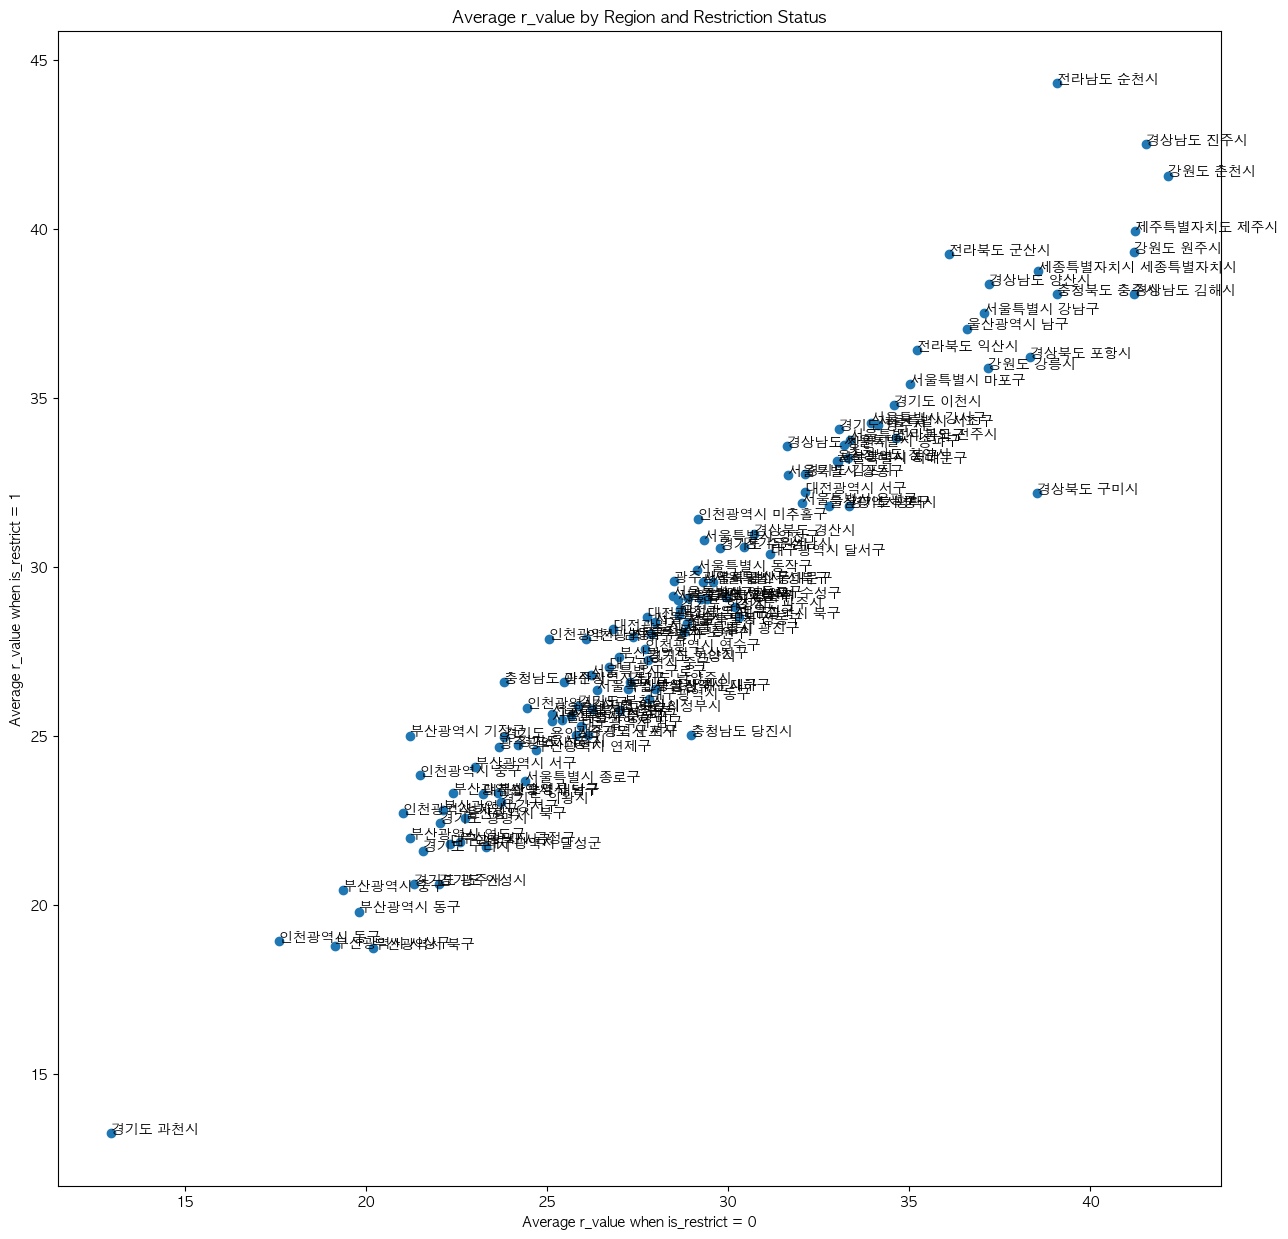

In [7]:
avg_r_values = data.groupby(['region', 'is_restrict']).r_value.mean().unstack()

plt.figure(figsize = (15,15))
plt.scatter(avg_r_values[0], avg_r_values[1])

# cursor = mplcursors.cursor(hover=True)
# cursor.connect("add", lambda sel: sel.annotation.set_text(avg_r_values.index[sel.target.index]))

# 각 지점에 지역 이름을 표시
for i, txt in enumerate(avg_r_values.index):
    plt.annotate(txt, (avg_r_values[0][i], avg_r_values[1][i]))
    
# 축 레이블 및 타이틀 설정
plt.xlabel('Average r_value when is_restrict = 0')
plt.ylabel('Average r_value when is_restrict = 1')
plt.title('Average r_value by Region and Restriction Status')

plt.show()



In [8]:
def visualize_silhouette_scores(data, method='kmeans', param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2, 15)
    results = []

    for i in clusters_range:
        if method == 'kmeans':
            clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        elif method == 'agglomerative':
            clusterer = AgglomerativeClustering(n_clusters=i)
        else:
            raise ValueError("Invalid method. Choose 'kmeans' or 'agglomerative'.")

        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    
    plt.figure()
    sns.heatmap(pd.pivot_table(result, index="n_clusters", values="silhouette_score"),annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.title(f"Silhouette Scores for {method.capitalize()} Clustering")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.show()

In [9]:
avg_r_values = avg_r_values.dropna() 

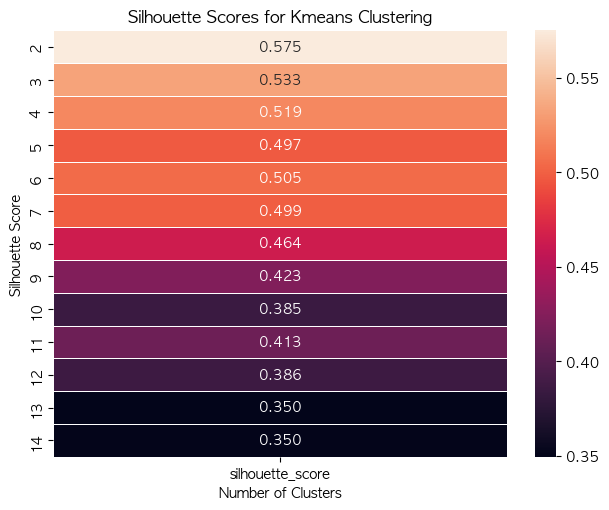

In [10]:
visualize_silhouette_scores(avg_r_values, method = 'kmeans')

K-Means Silhouette Score: 0.52


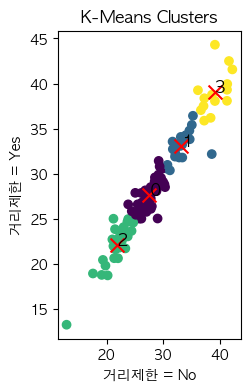

In [11]:
# K-means 클러스터링
# NaN 값이나 무한대 값을 가진 행을 제거하거나 대체
#avg_r_values = avg_r_values.dropna()  # NaN 값을 가진 행을 제거

# 또는 NaN 값을 평균으로 대체 
# avg_r_values.fillna(avg_r_values.mean(), inplace=True)  # NaN 값을 평균으로 대체

random.seed(1234)
# 이후 K-means 클러스터링 수행
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans_clusters = kmeans.fit_predict(avg_r_values)
kmeans_silhouette_score = silhouette_score(avg_r_values, kmeans_clusters)
print(f"K-Means Silhouette Score: {kmeans_silhouette_score:.2f}")

# 시각화
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.scatter(avg_r_values[0], avg_r_values[1], c=kmeans_clusters, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
plt.title('K-Means Clusters')
plt.xlabel('거리제한 = No')
plt.ylabel('거리제한 = Yes')

# 클러스터 센터에 번호 표시
for i, cluster_num in enumerate(np.unique(kmeans_clusters)):
    plt.text(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], str(cluster_num), color='black', fontsize=12)

plt.show()


In [12]:
avg_r_values['clusters_nums'] = kmeans_clusters
print(avg_r_values['clusters_nums'].value_counts()) # 14,29,23,50

clusters_nums
0    50
2    29
1    23
3    14
Name: count, dtype: int64


In [13]:
# avg_r_values의 인덱스를 리셋하여 'region'을 열로 변환
avg_r_values_reset = avg_r_values.reset_index()
print(avg_r_values_reset.head(2))


is_restrict   region          0          1  clusters_nums
0            강원도 강릉시  37.184052  35.882353              3
1            강원도 원주시  41.203519  39.311099              3


## R value 이미 높은 지역 

## 신규 비율 

clusters_nums
0.0    50
2.0    29
1.0    23
3.0    14
Name: count, dtype: int64
(14, 4)
is_restrict    region          0          1  clusters_nums
0             강원도 강릉시  41.398964  44.262295            3.0
1             강원도 원주시  35.016839  46.339840            3.0
2             강원도 춘천시  29.886681  33.135473            3.0
28           경상남도 김해시  30.853181  32.331859            3.0
29           경상남도 양산시  34.361700  39.542019            3.0


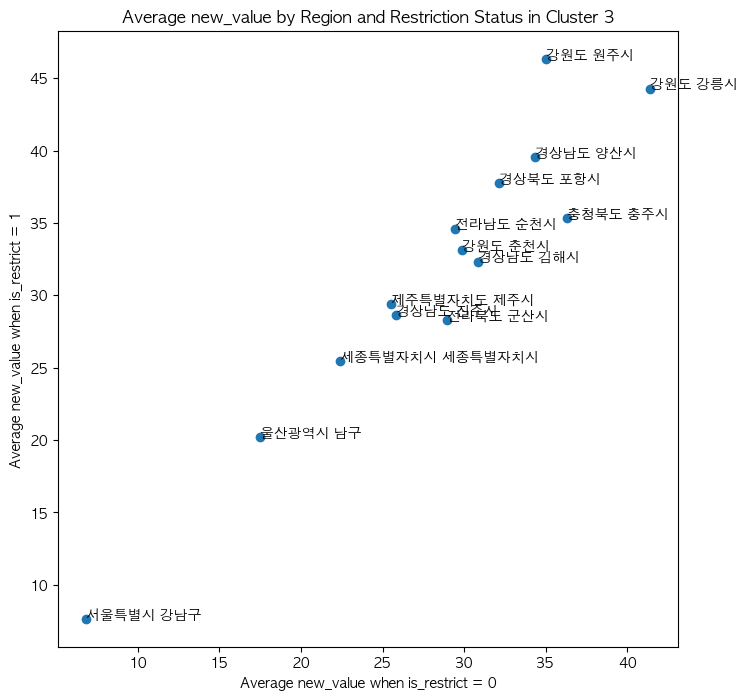

In [24]:
avg_new_values = data.groupby(['region', 'is_restrict']).new_rider_per.mean().unstack()
avg_new_values = pd.merge(avg_new_values, avg_r_values_reset[['region', 'clusters_nums']], on='region', how='left')
print(avg_new_values['clusters_nums'].value_counts())

up_r_region = avg_new_values[avg_new_values['clusters_nums'] == 3.0]
print(up_r_region.shape) 
print(up_r_region.head())

plt.figure(figsize = (8,8))
plt.scatter(up_r_region[0], up_r_region[1])
plt.xlabel('Average new_value when is_restrict = 0')
plt.ylabel('Average new_value when is_restrict = 1')
plt.title('Average new_value by Region and Restriction Status in Cluster 3')

# 각 지점에 지역 이름을 표시
for i, txt in enumerate(up_r_region['region']):
    plt.annotate(txt, (up_r_region[0].iloc[i], up_r_region[1].iloc[i]))

plt.show()

## 신규 라이더 R value 

clusters_nums
0.0    50
2.0    29
1.0    23
3.0    14
Name: count, dtype: int64
(14, 4)
is_restrict    region          0          1  clusters_nums
0             강원도 강릉시  38.616175  33.750000            3.0
1             강원도 원주시  37.650154  41.126194            3.0
2             강원도 춘천시  37.576924  34.794627            3.0
28           경상남도 김해시  37.081330  32.308563            3.0
29           경상남도 양산시  35.746819  34.888161            3.0


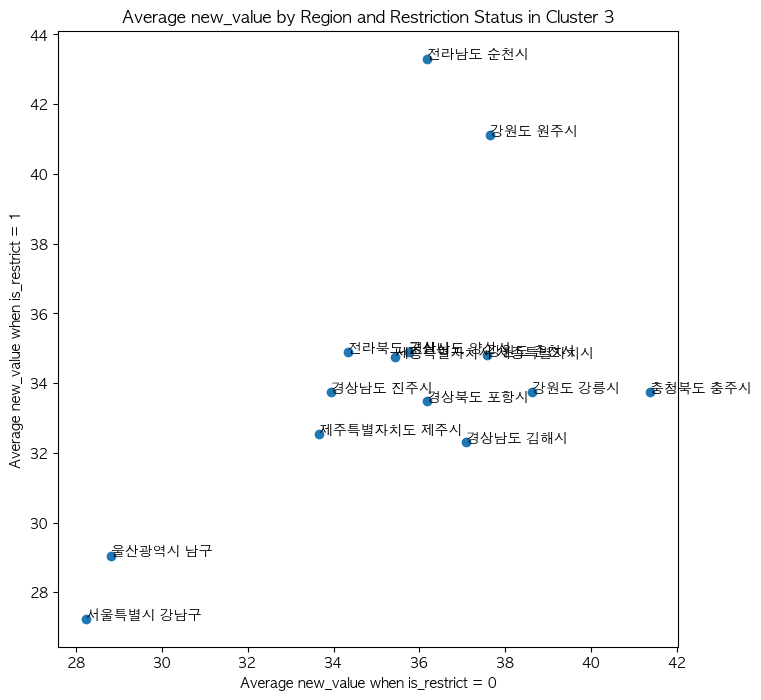

In [25]:
avg_new_values = data.groupby(['region', 'is_restrict']).r_value_new.mean().unstack()
avg_new_values = pd.merge(avg_new_values, avg_r_values_reset[['region', 'clusters_nums']], on='region', how='left')
print(avg_new_values['clusters_nums'].value_counts())

up_r_region = avg_new_values[avg_new_values['clusters_nums'] == 3.0]
print(up_r_region.shape) 
print(up_r_region.head())

plt.figure(figsize = (8,8))
plt.scatter(up_r_region[0], up_r_region[1])
plt.xlabel('Average new_value when is_restrict = 0')
plt.ylabel('Average new_value when is_restrict = 1')
plt.title('Average new_value by Region and Restriction Status in Cluster 3')

# 각 지점에 지역 이름을 표시
for i, txt in enumerate(up_r_region['region']):
    plt.annotate(txt, (up_r_region[0].iloc[i], up_r_region[1].iloc[i]))

plt.show()

## 기존 라이더 R value

clusters_nums
0.0    50
2.0    29
1.0    23
3.0    14
Name: count, dtype: int64
(14, 4)
is_restrict    region          0          1  clusters_nums
0             강원도 강릉시  36.626749  37.777778            3.0
1             강원도 원주시  43.513141  37.880793            3.0
2             강원도 춘천시  44.592660  45.895246            3.0
28           경상남도 김해시  43.168438  41.564159            3.0
29           경상남도 양산시  38.115271  41.053020            3.0


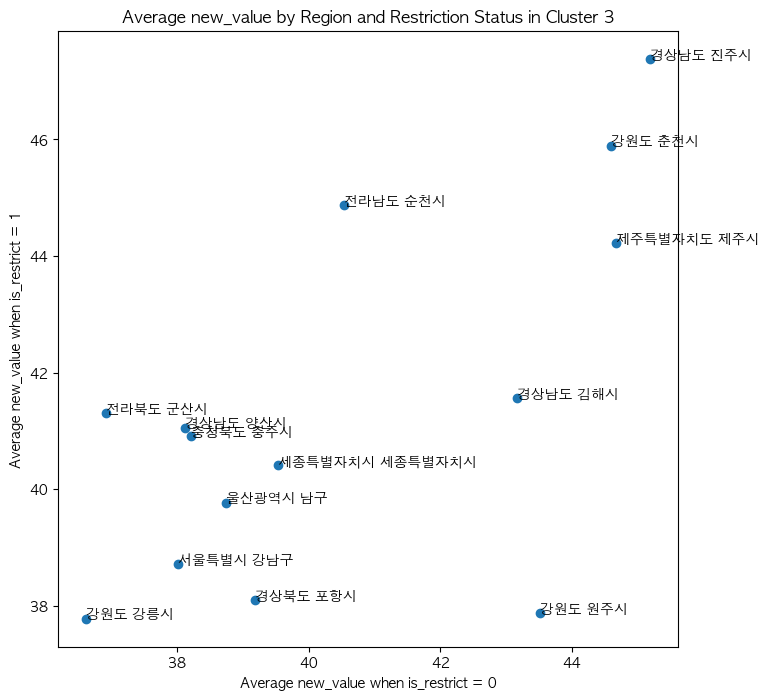

In [26]:
avg_new_values = data.groupby(['region', 'is_restrict']).r_value_old.mean().unstack()
avg_new_values = pd.merge(avg_new_values, avg_r_values_reset[['region', 'clusters_nums']], on='region', how='left')
print(avg_new_values['clusters_nums'].value_counts())

up_r_region = avg_new_values[avg_new_values['clusters_nums'] == 3.0]
print(up_r_region.shape) 
print(up_r_region.head())

plt.figure(figsize = (8,8))
plt.scatter(up_r_region[0], up_r_region[1])
plt.xlabel('Average new_value when is_restrict = 0')
plt.ylabel('Average new_value when is_restrict = 1')
plt.title('Average new_value by Region and Restriction Status in Cluster 3')

# 각 지점에 지역 이름을 표시
for i, txt in enumerate(up_r_region['region']):
    plt.annotate(txt, (up_r_region[0].iloc[i], up_r_region[1].iloc[i]))

plt.show()

## rgn1 나눠서 그 안에서 rgn2 단위로 신규 비율 그래프 그리기

In [44]:
new_df = data.groupby(['rgn1_nm', 'rgn2_nm', 'is_restrict']).new_rider_per.mean().unstack()
print(new_df)

is_restrict               0          1
rgn1_nm rgn2_nm                       
강원도     강릉시       41.398964  44.262295
        원주시       35.016839  46.339840
        춘천시       29.886681  33.135473
경기도     고양시 덕양구   14.288029  15.057279
        고양시 일산동구  14.220543  16.249550
...                     ...        ...
충청북도    청주시 상당구   33.114247  38.971637
        청주시 서원구   32.011604  37.250158
        청주시 청원구   33.334053  40.442934
        청주시 흥덕구   31.779658  36.048629
        충주시       36.334011  35.324675

[145 rows x 2 columns]


In [45]:
unique_rgn1 = new_df.index.get_level_values('rgn1_nm').unique()
print(unique_rgn1)

Index(['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '서울특별시', '세종특별자치시', '울산광역시', '인천광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도',
       '충청북도'],
      dtype='object', name='rgn1_nm')


In [46]:
unique_counts = new_df.reset_index().groupby('rgn1_nm')['rgn2_nm'].nunique()
print(unique_counts)


rgn1_nm
강원도         3
경기도        36
경상남도        8
경상북도        4
광주광역시       5
대구광역시       8
대전광역시       5
부산광역시      16
서울특별시      25
세종특별자치시     1
울산광역시       5
인천광역시       8
전라남도        4
전라북도        5
제주특별자치도     2
충청남도        5
충청북도        5
Name: rgn2_nm, dtype: int64


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


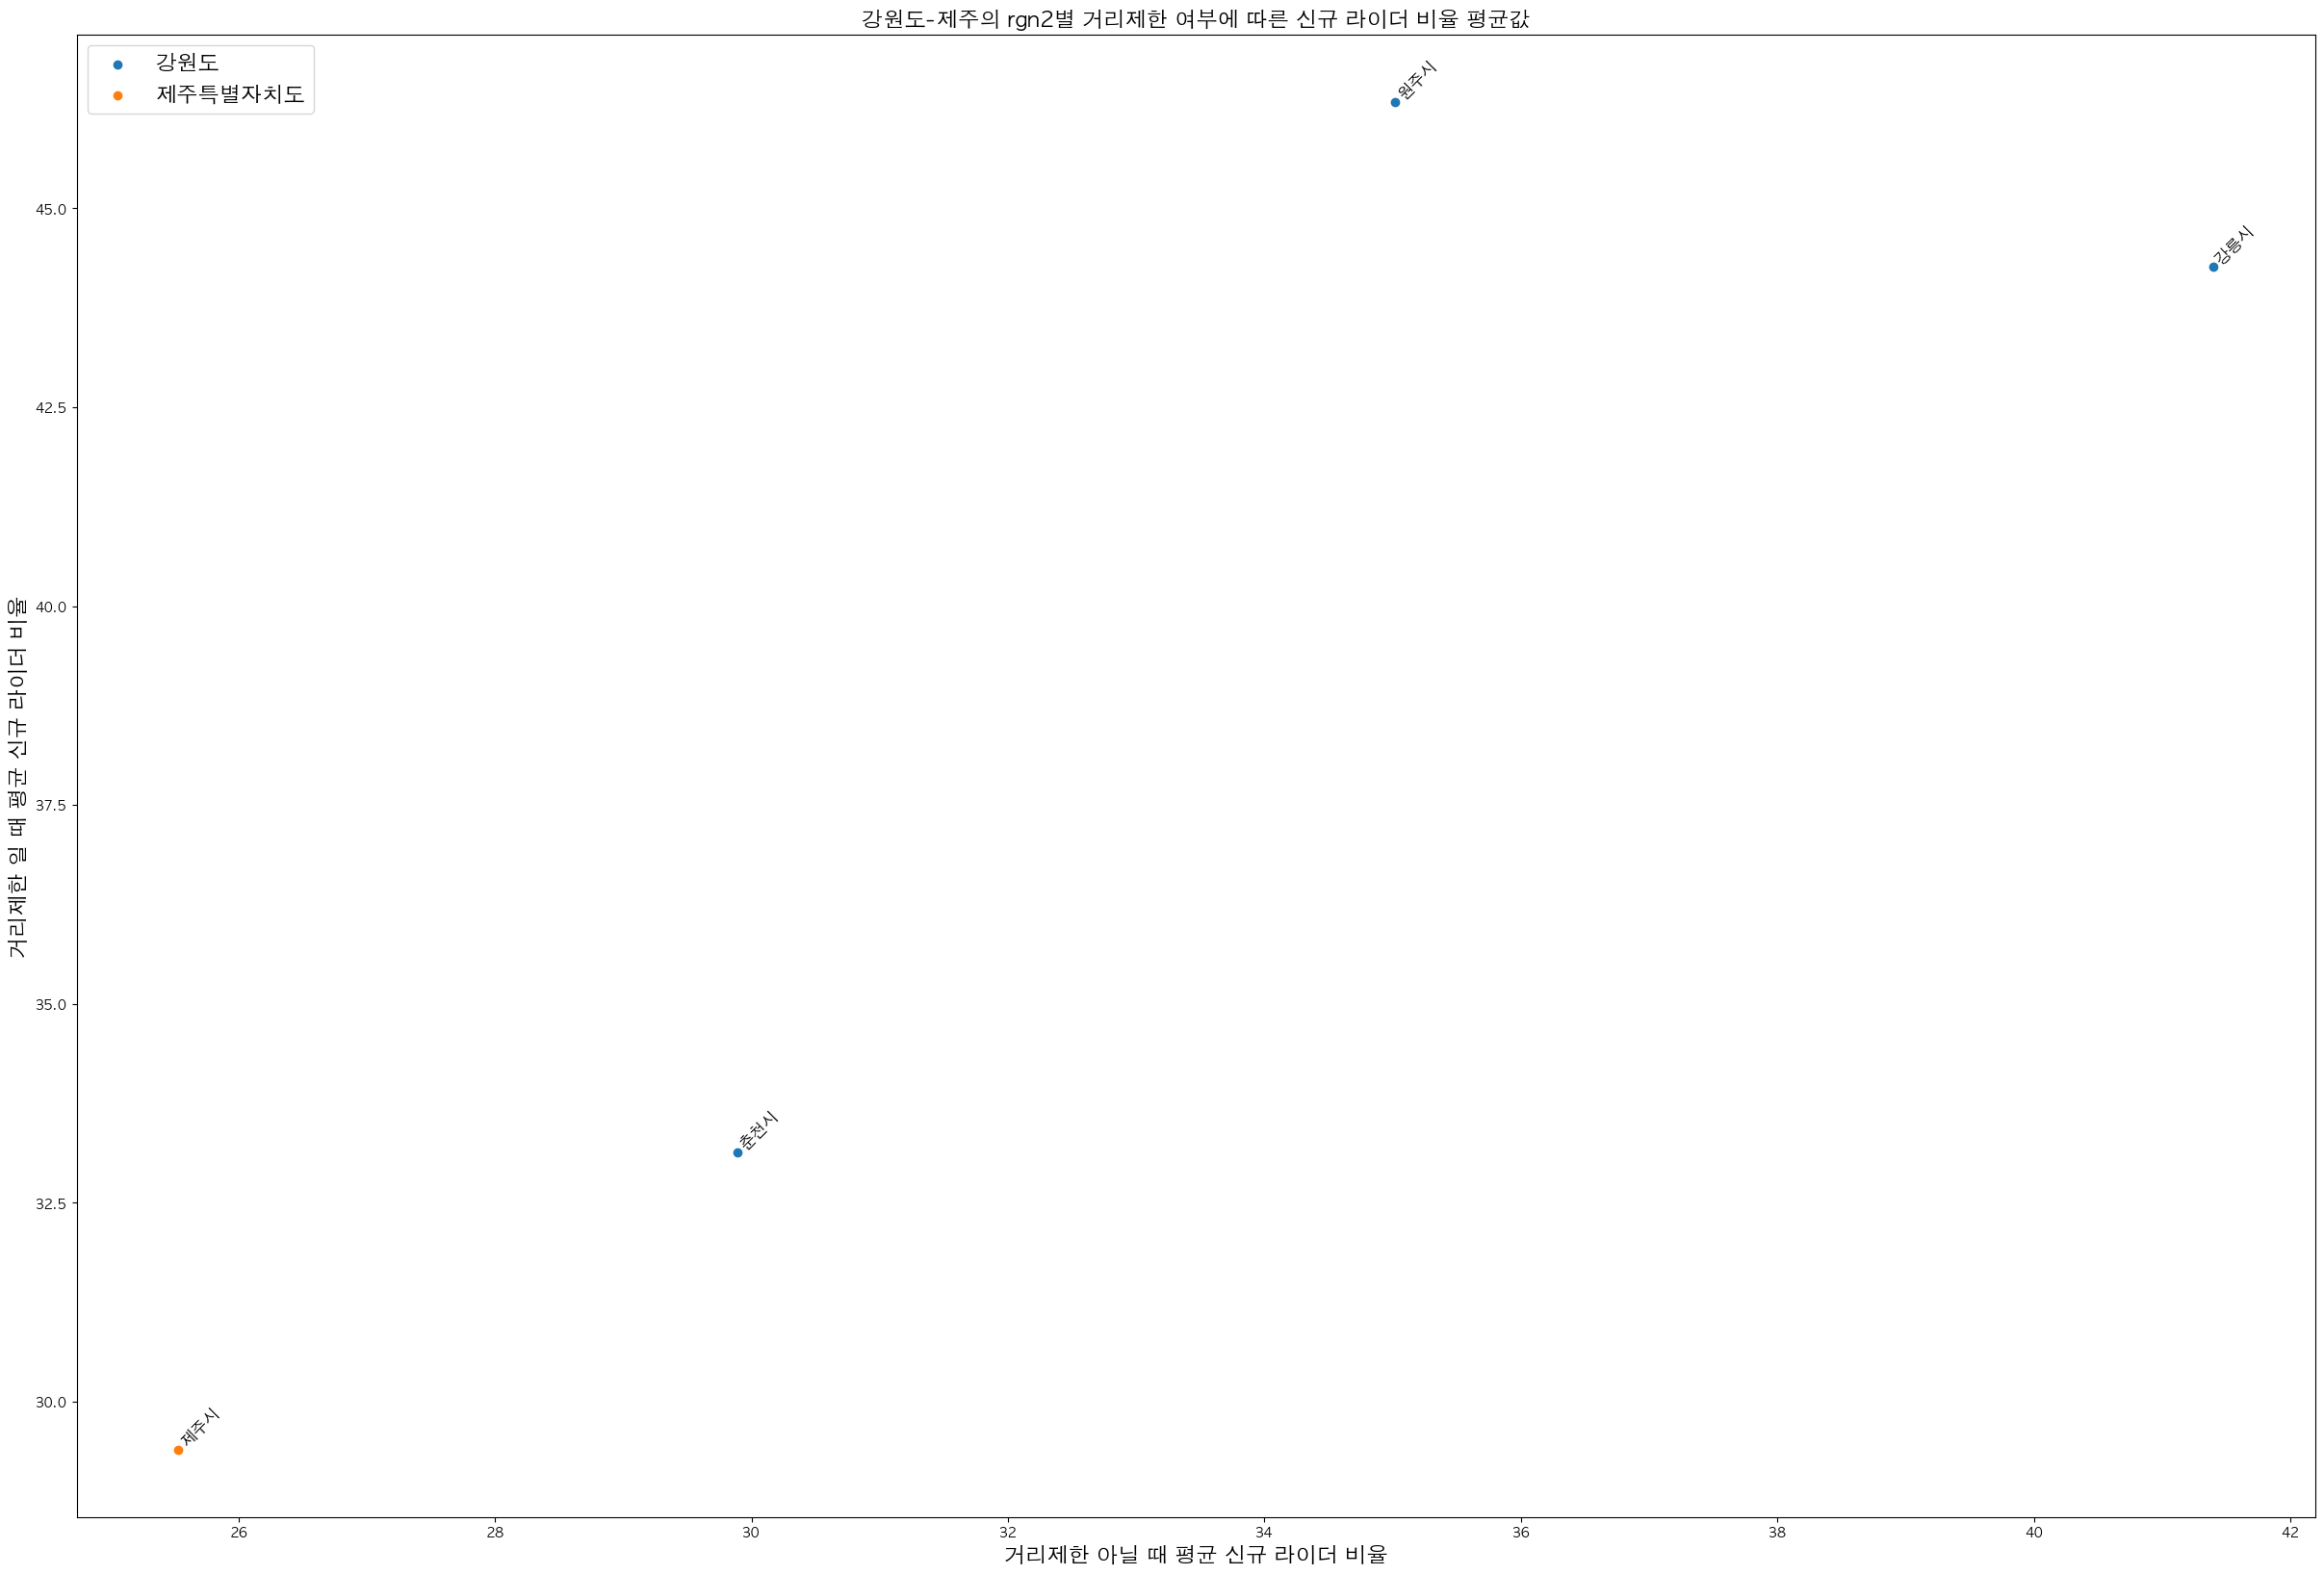

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


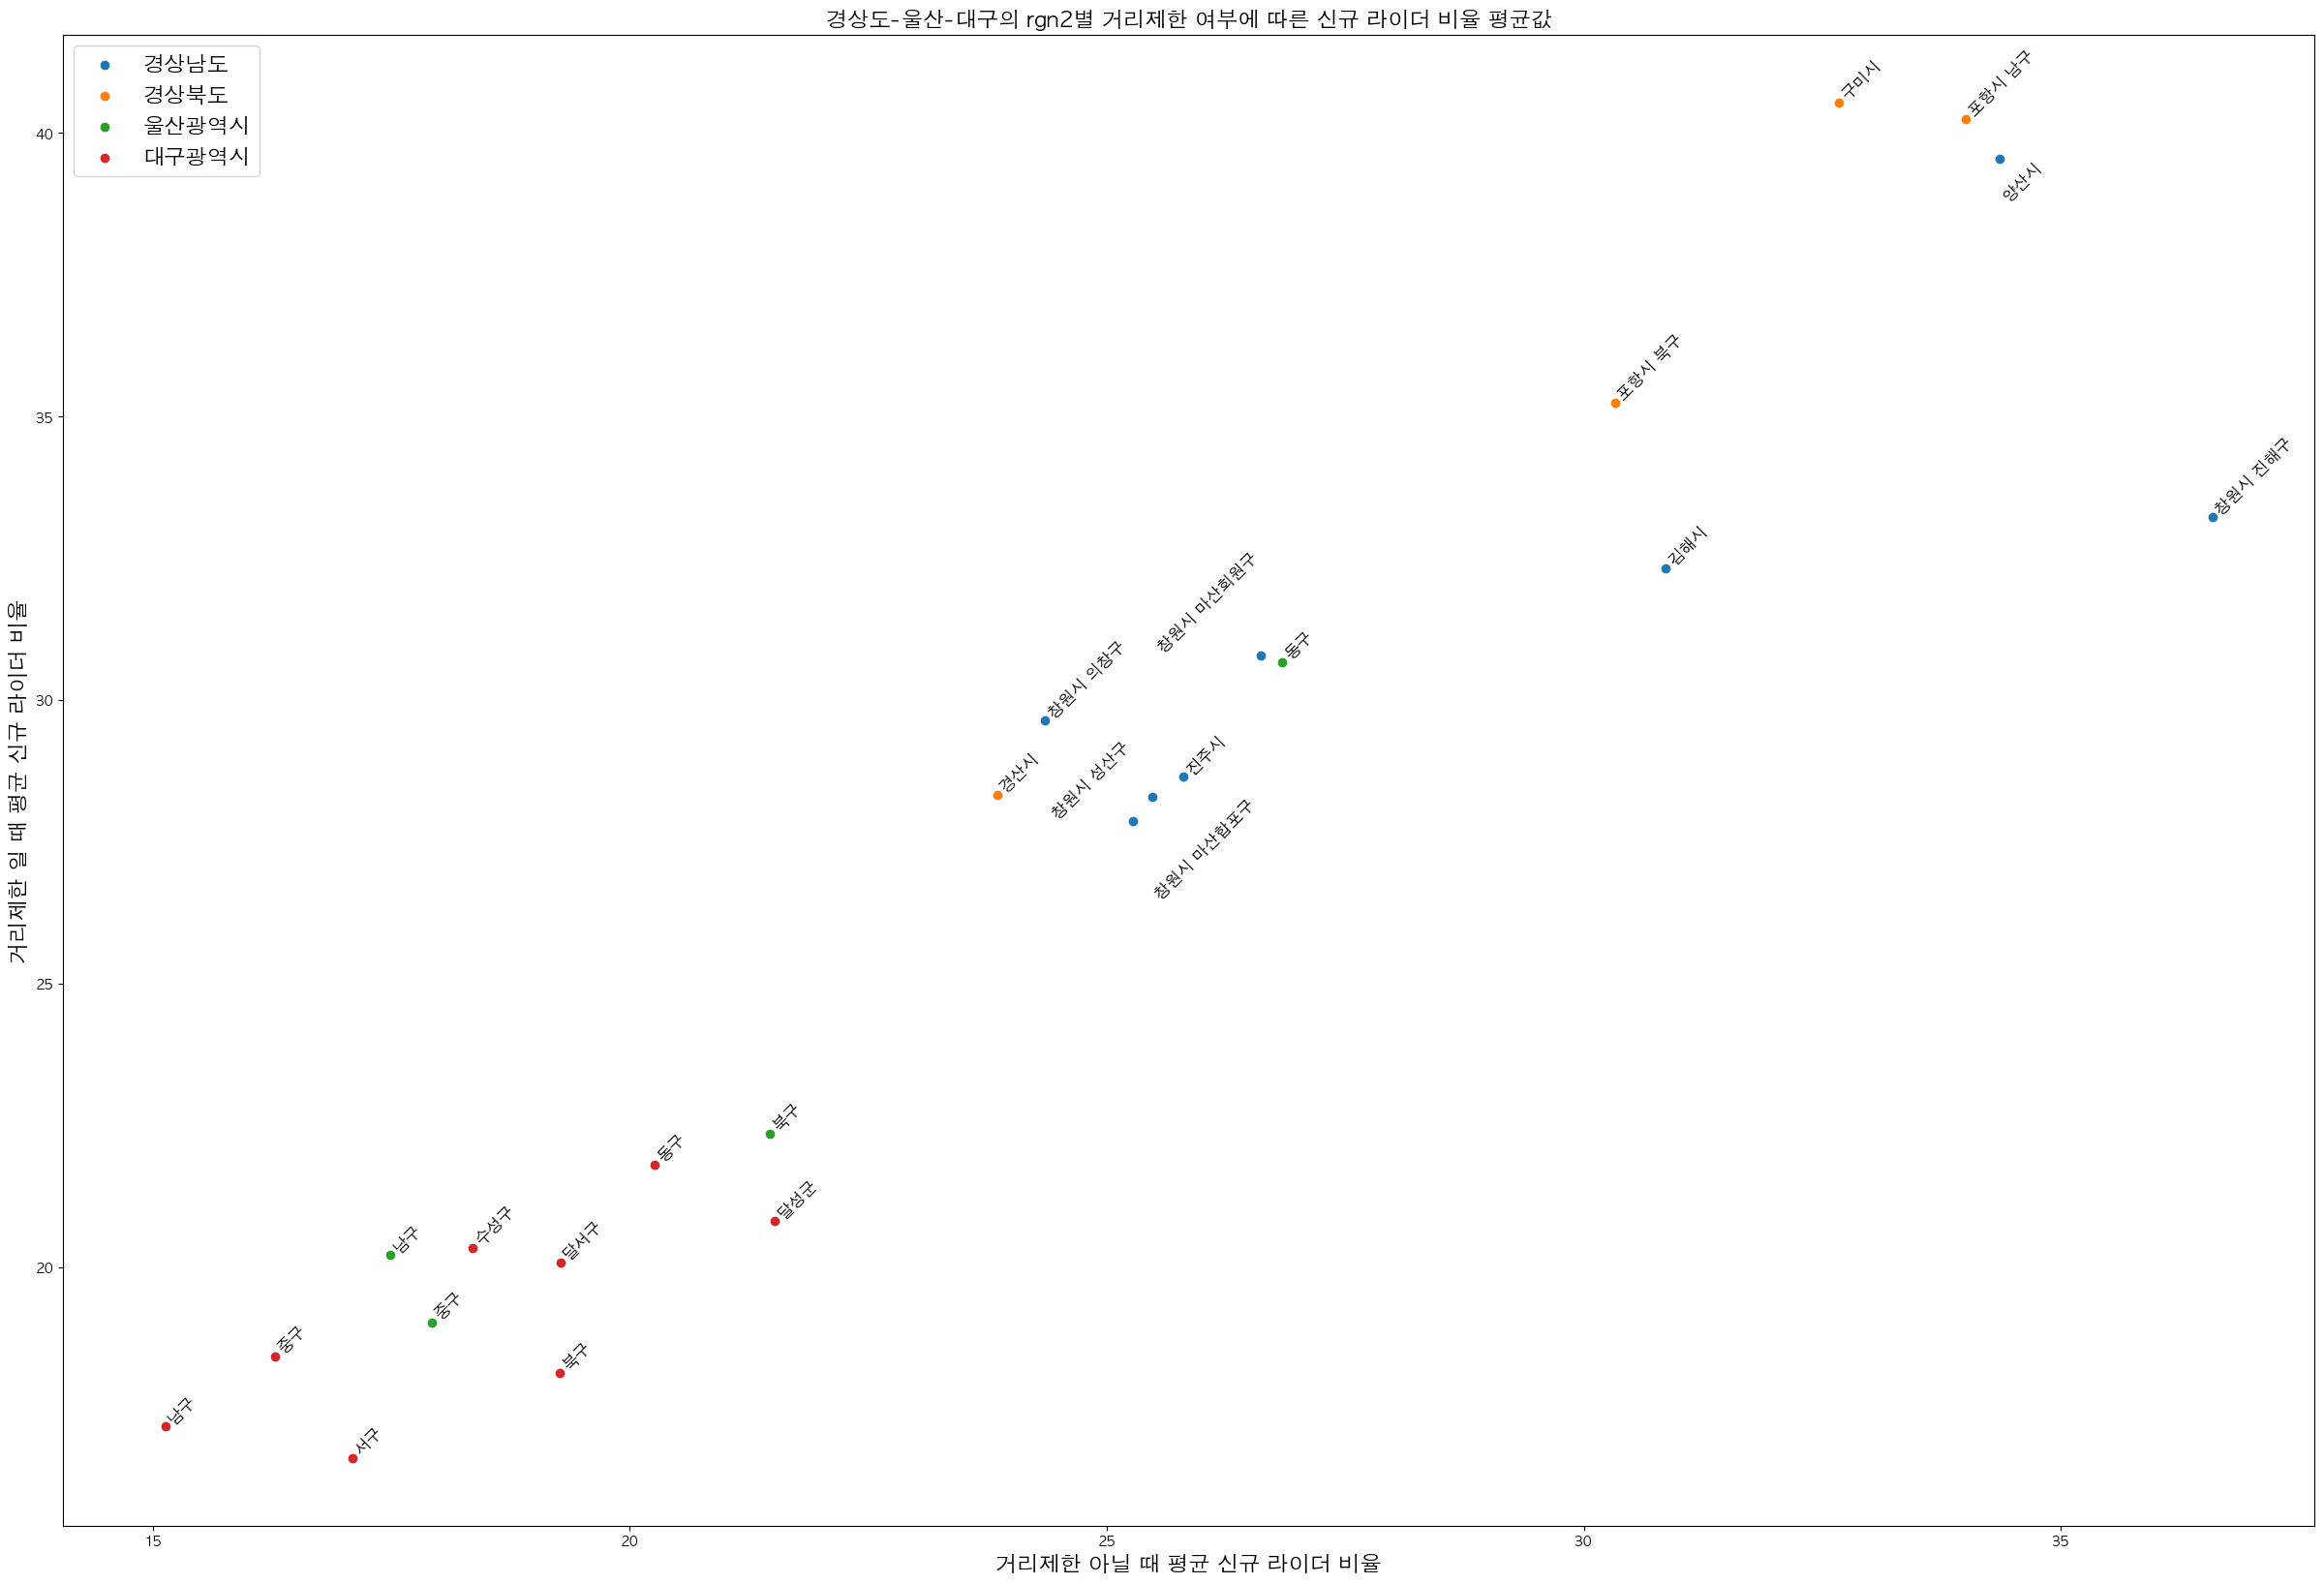

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


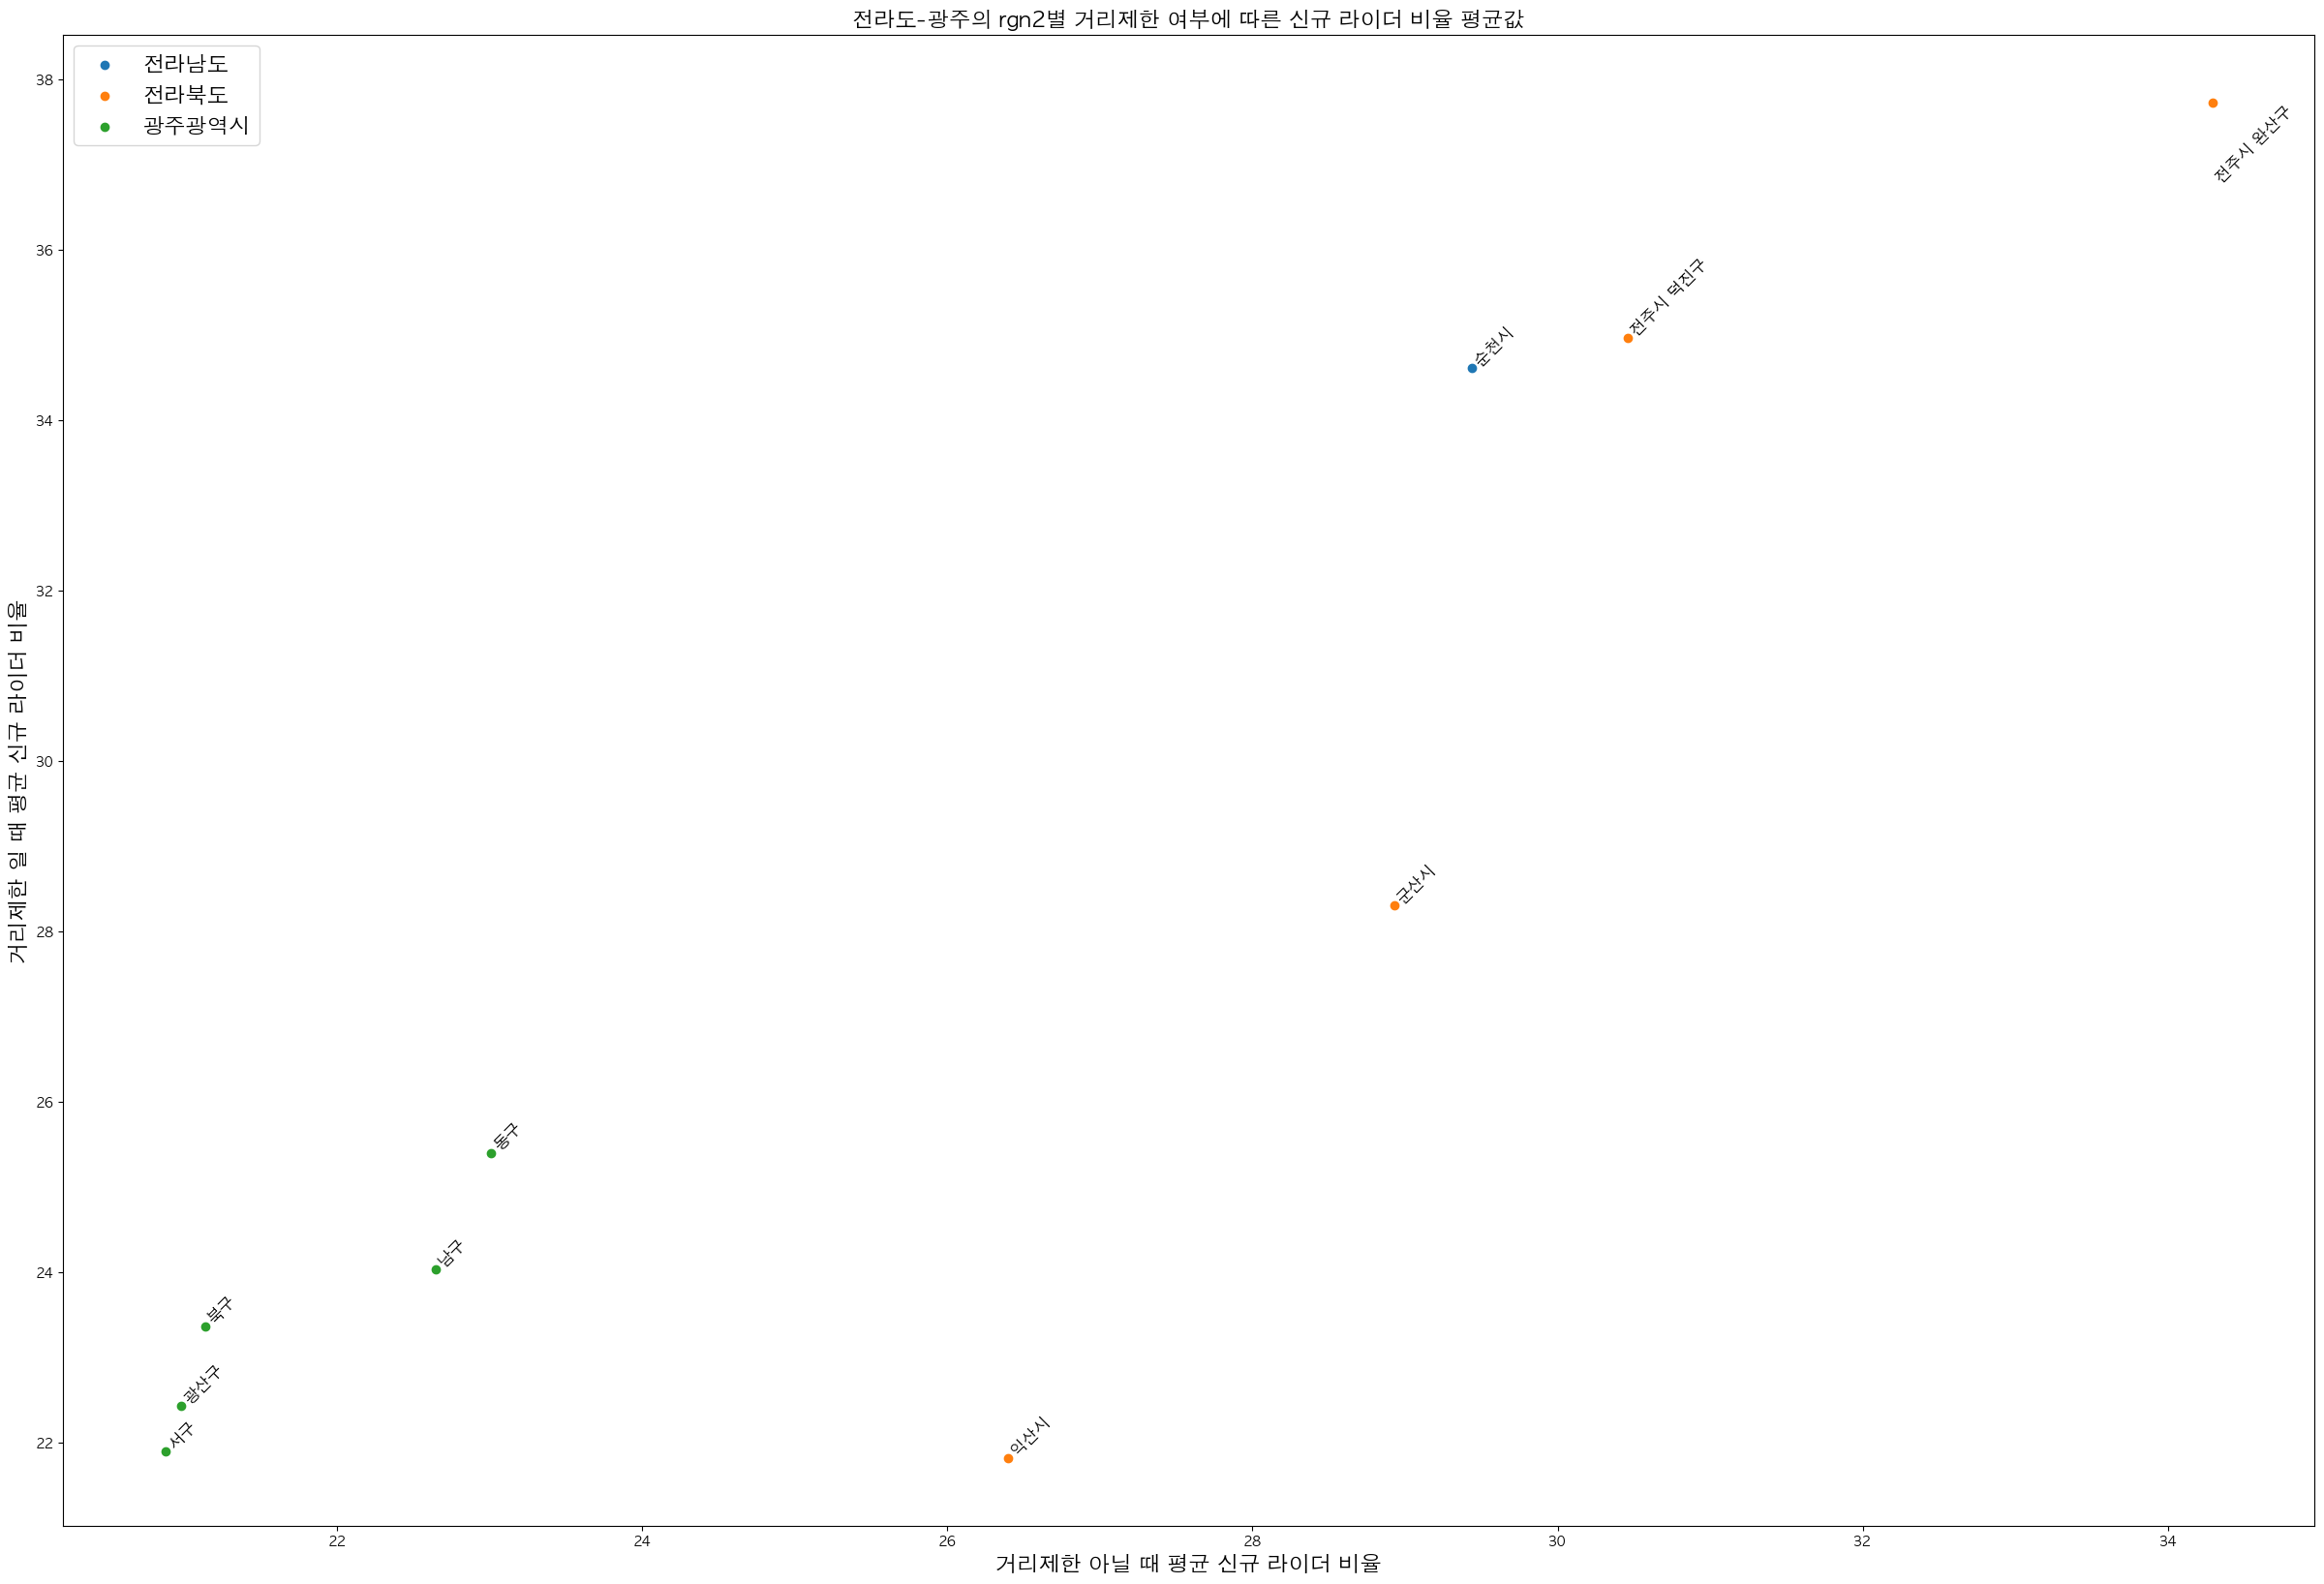

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


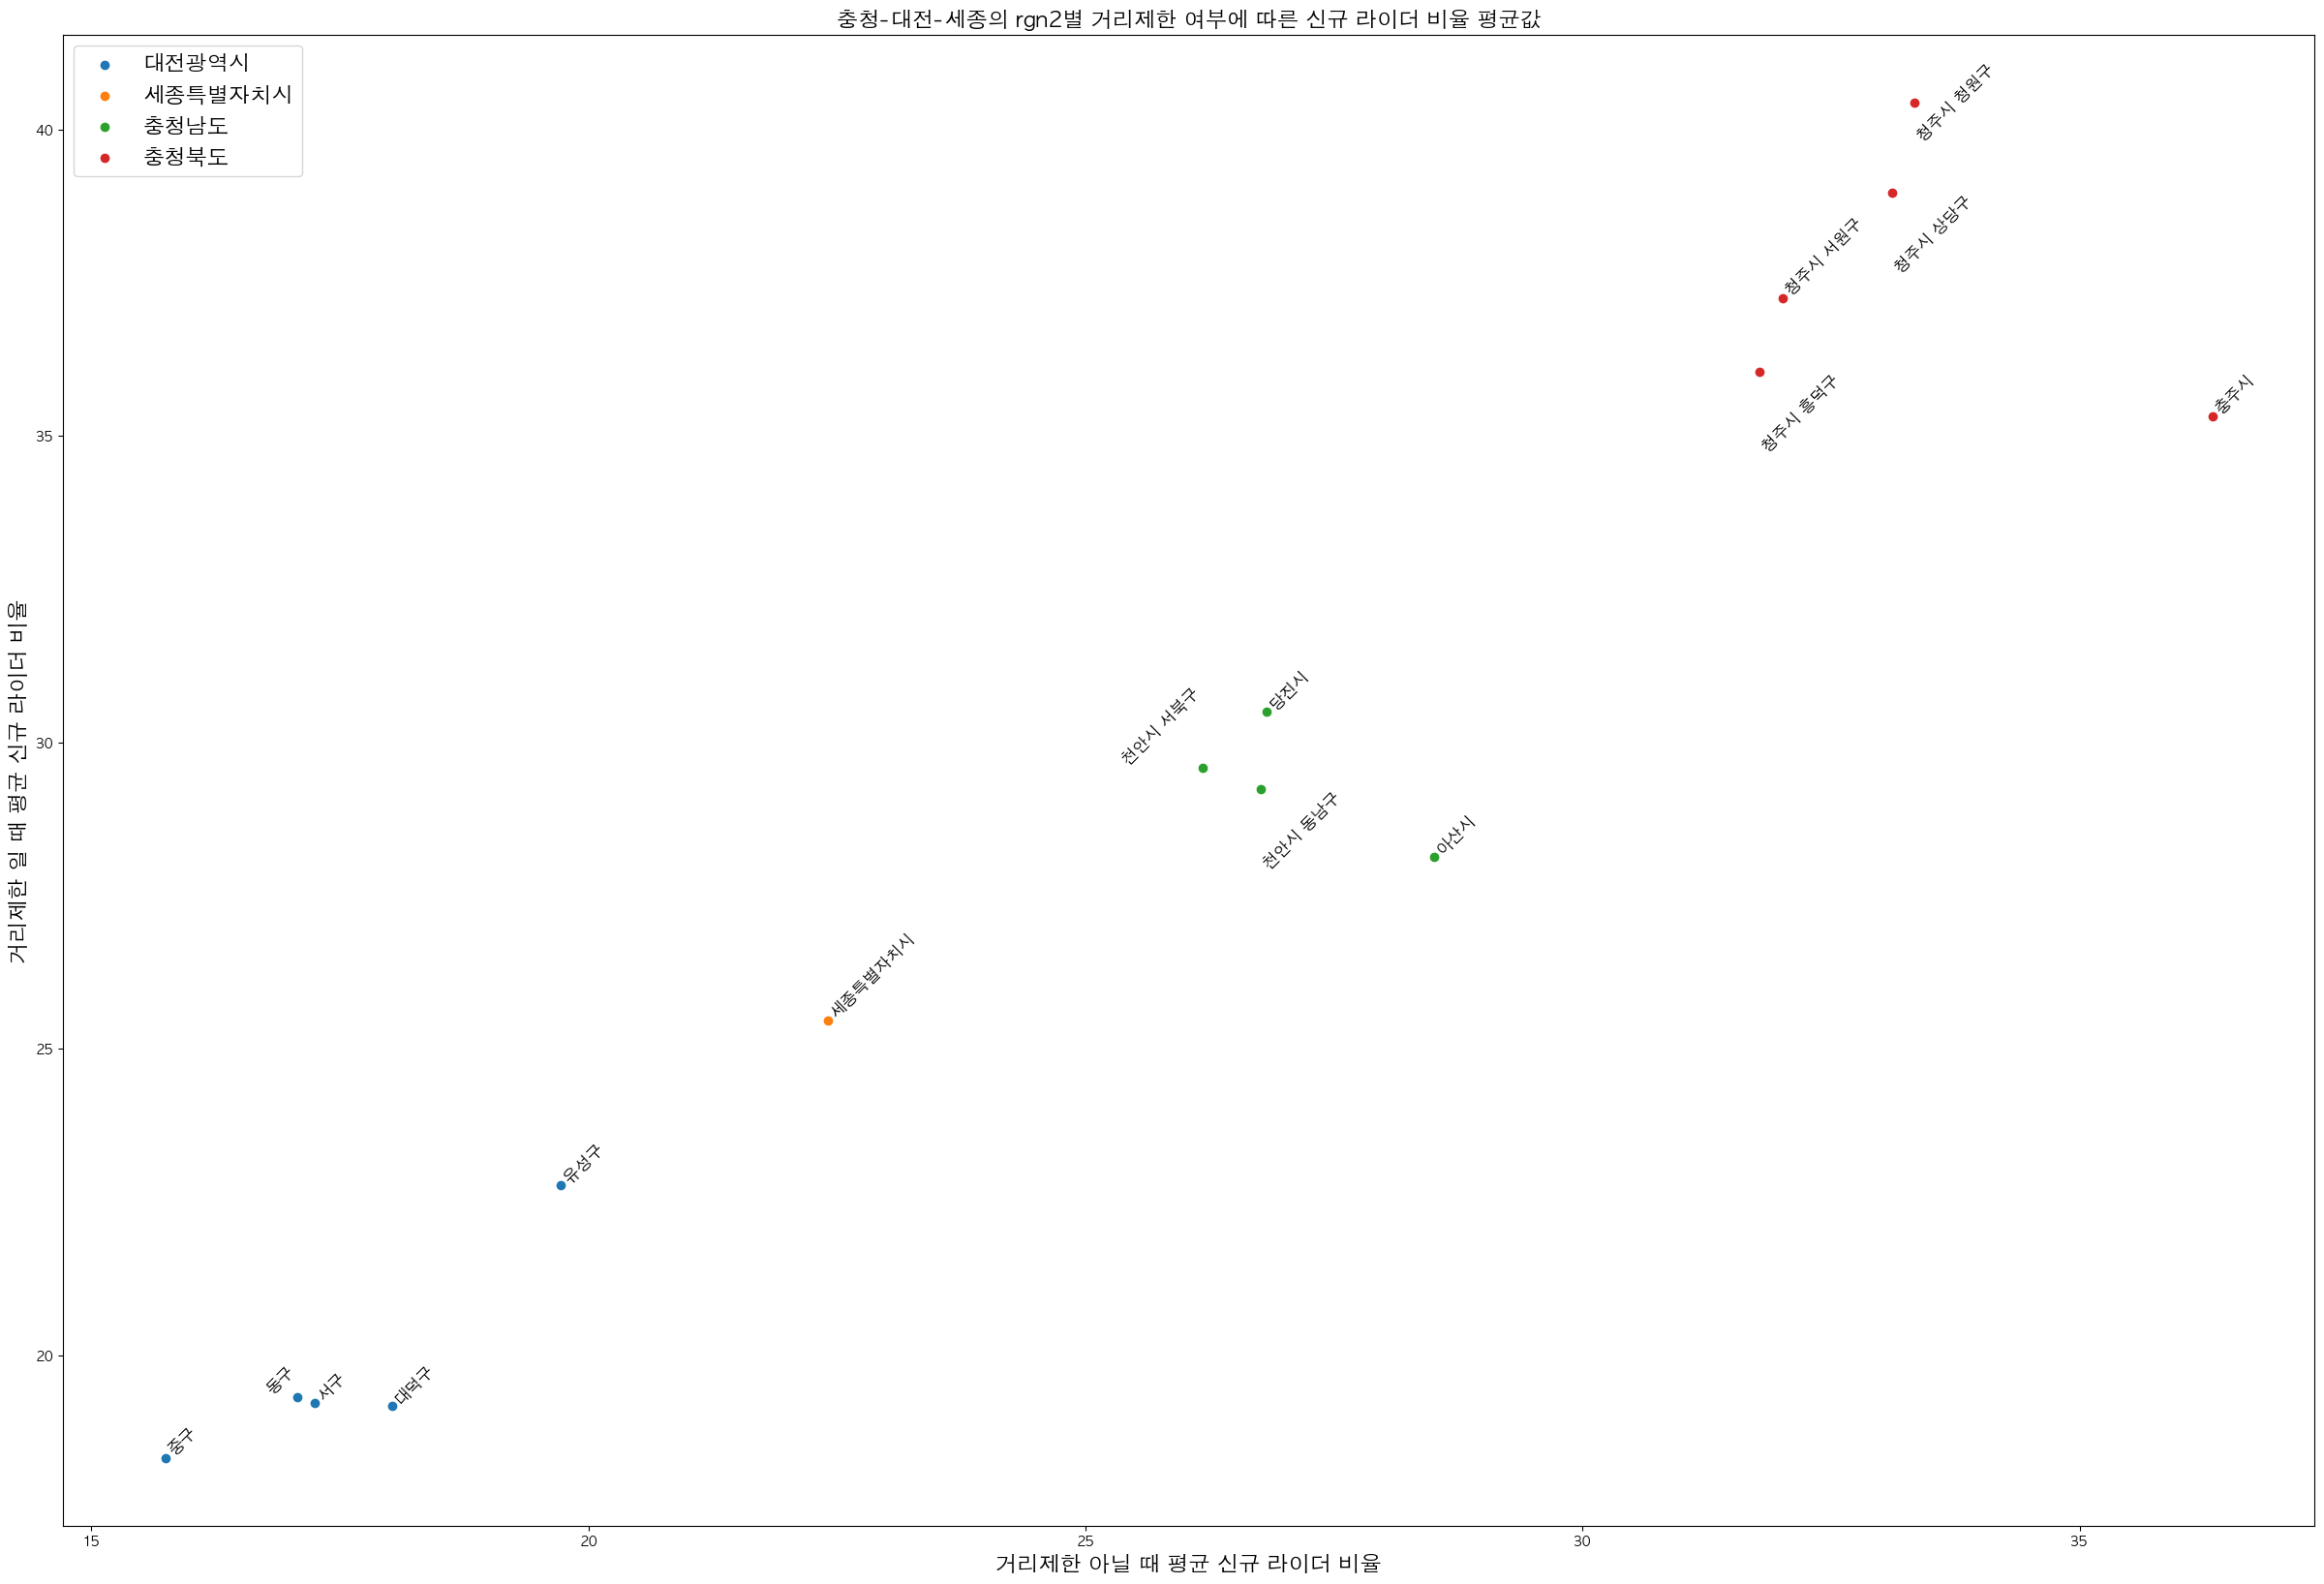

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


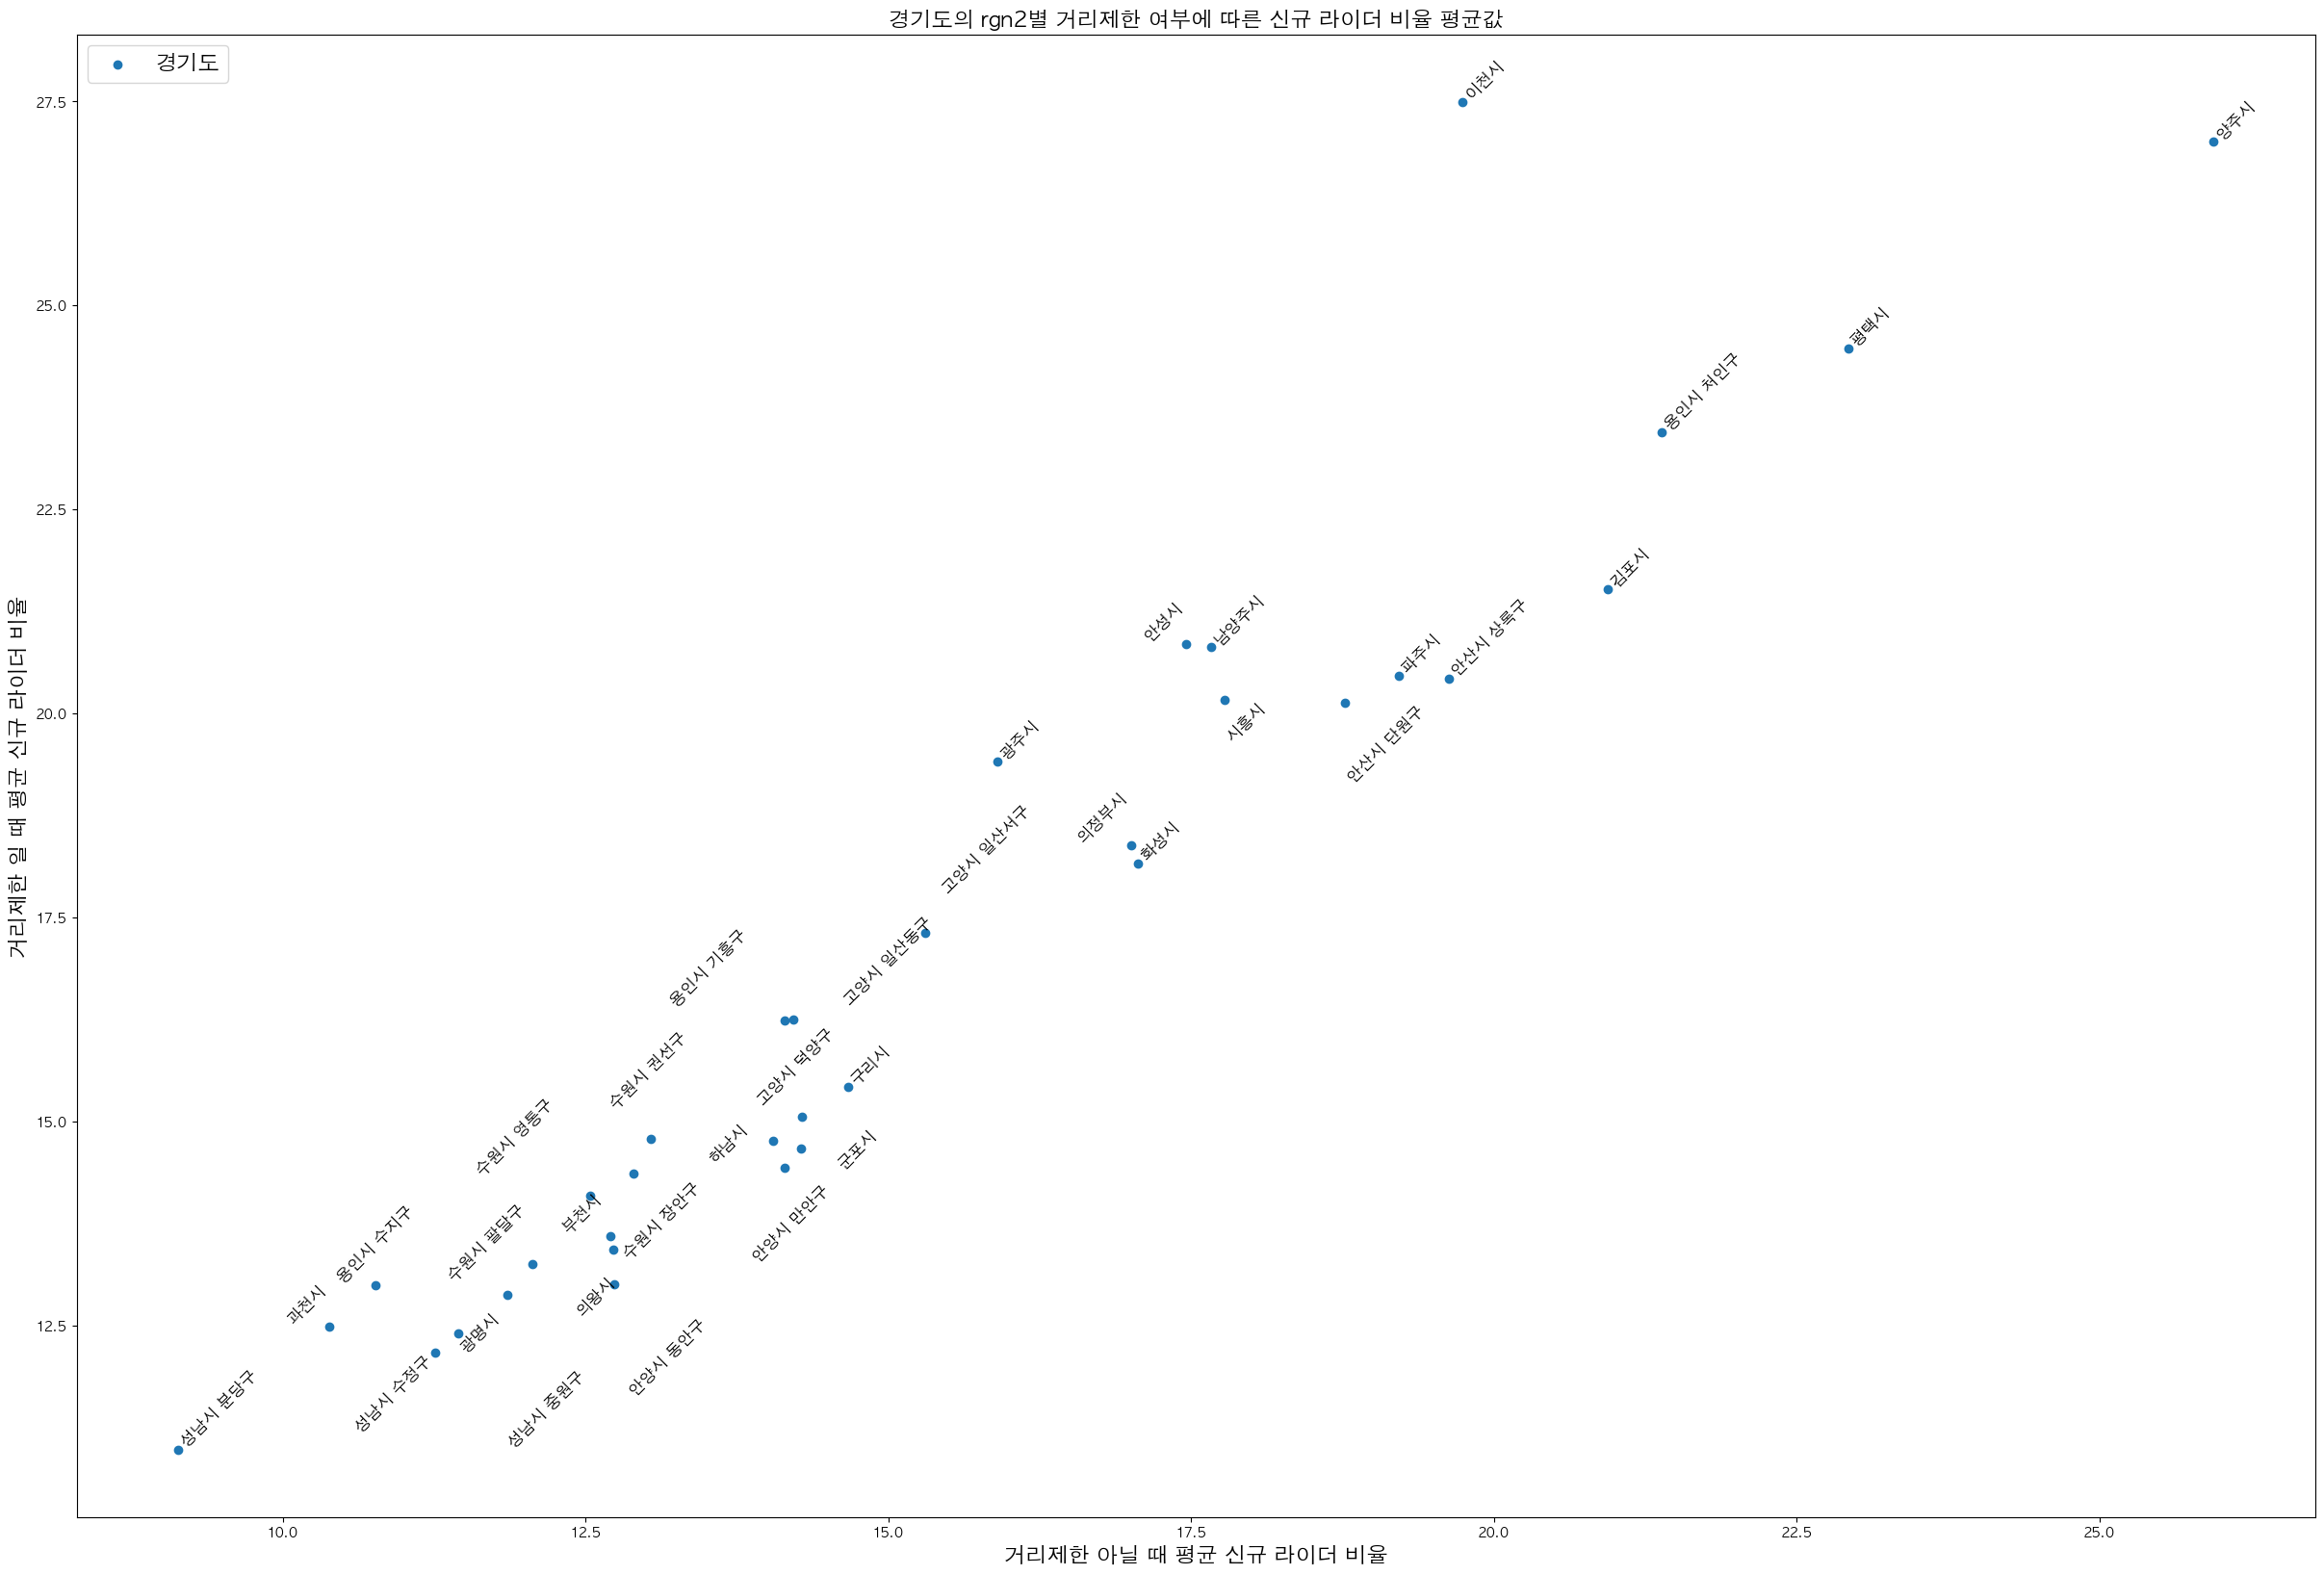

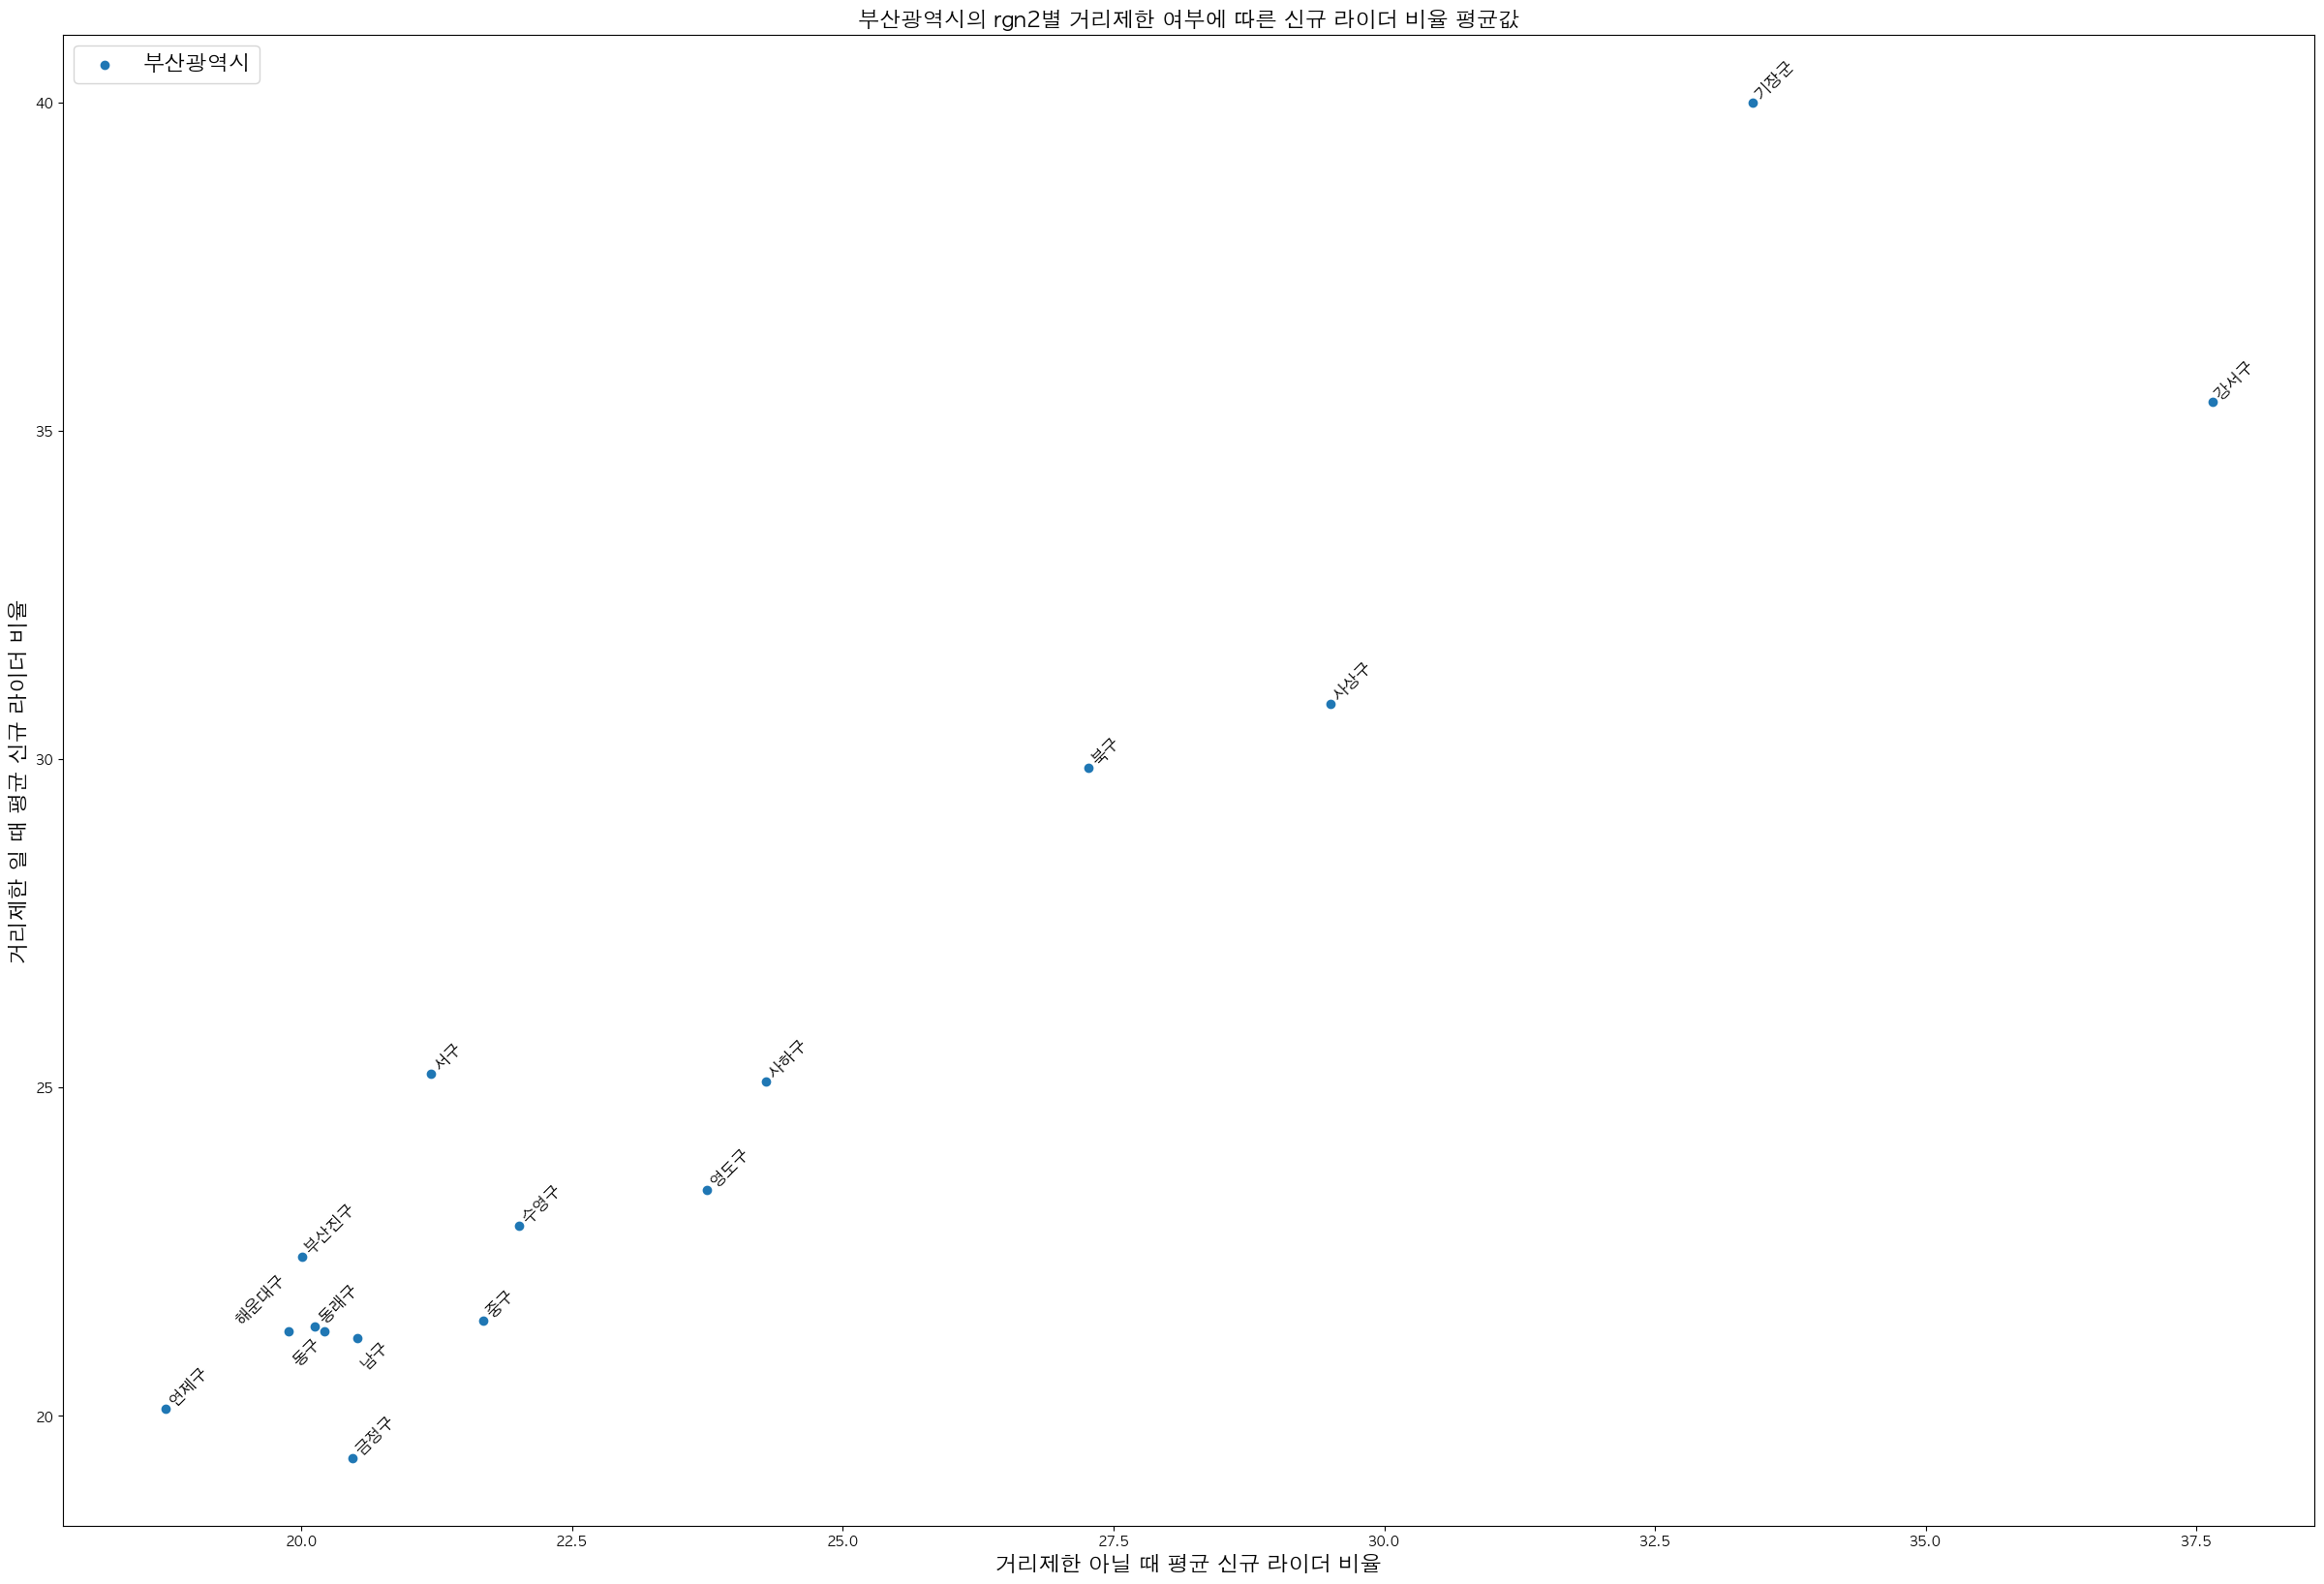

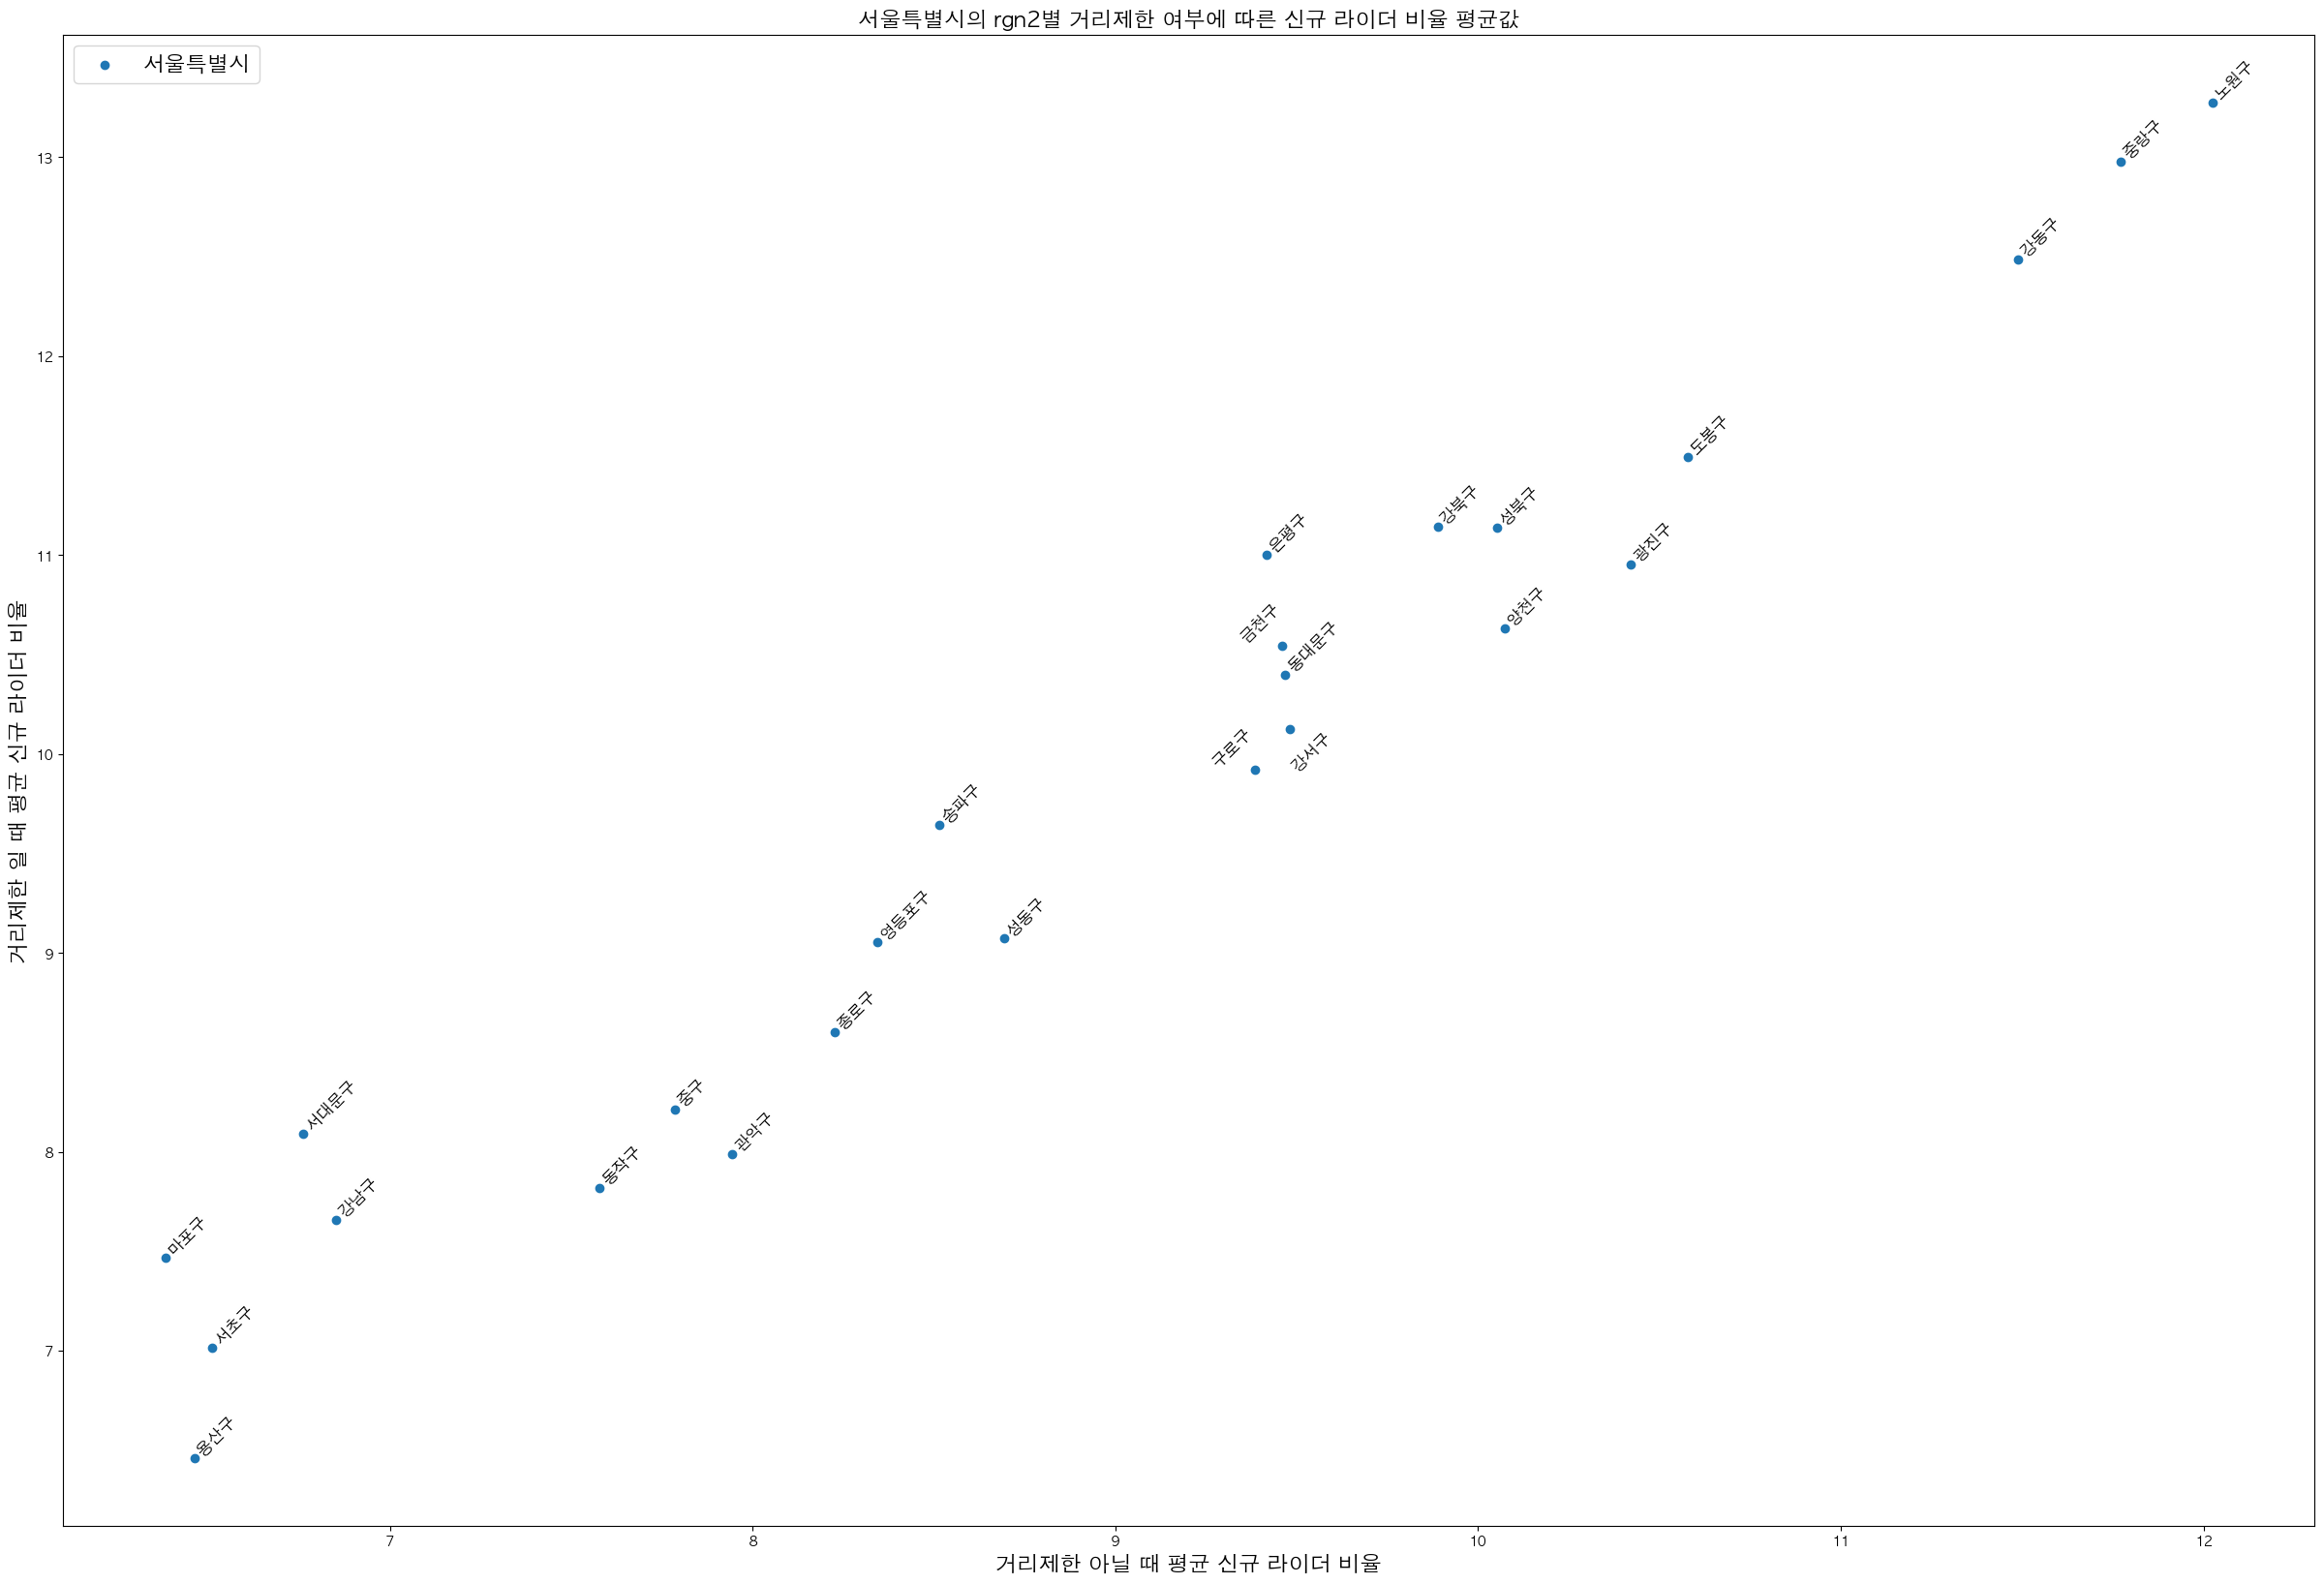

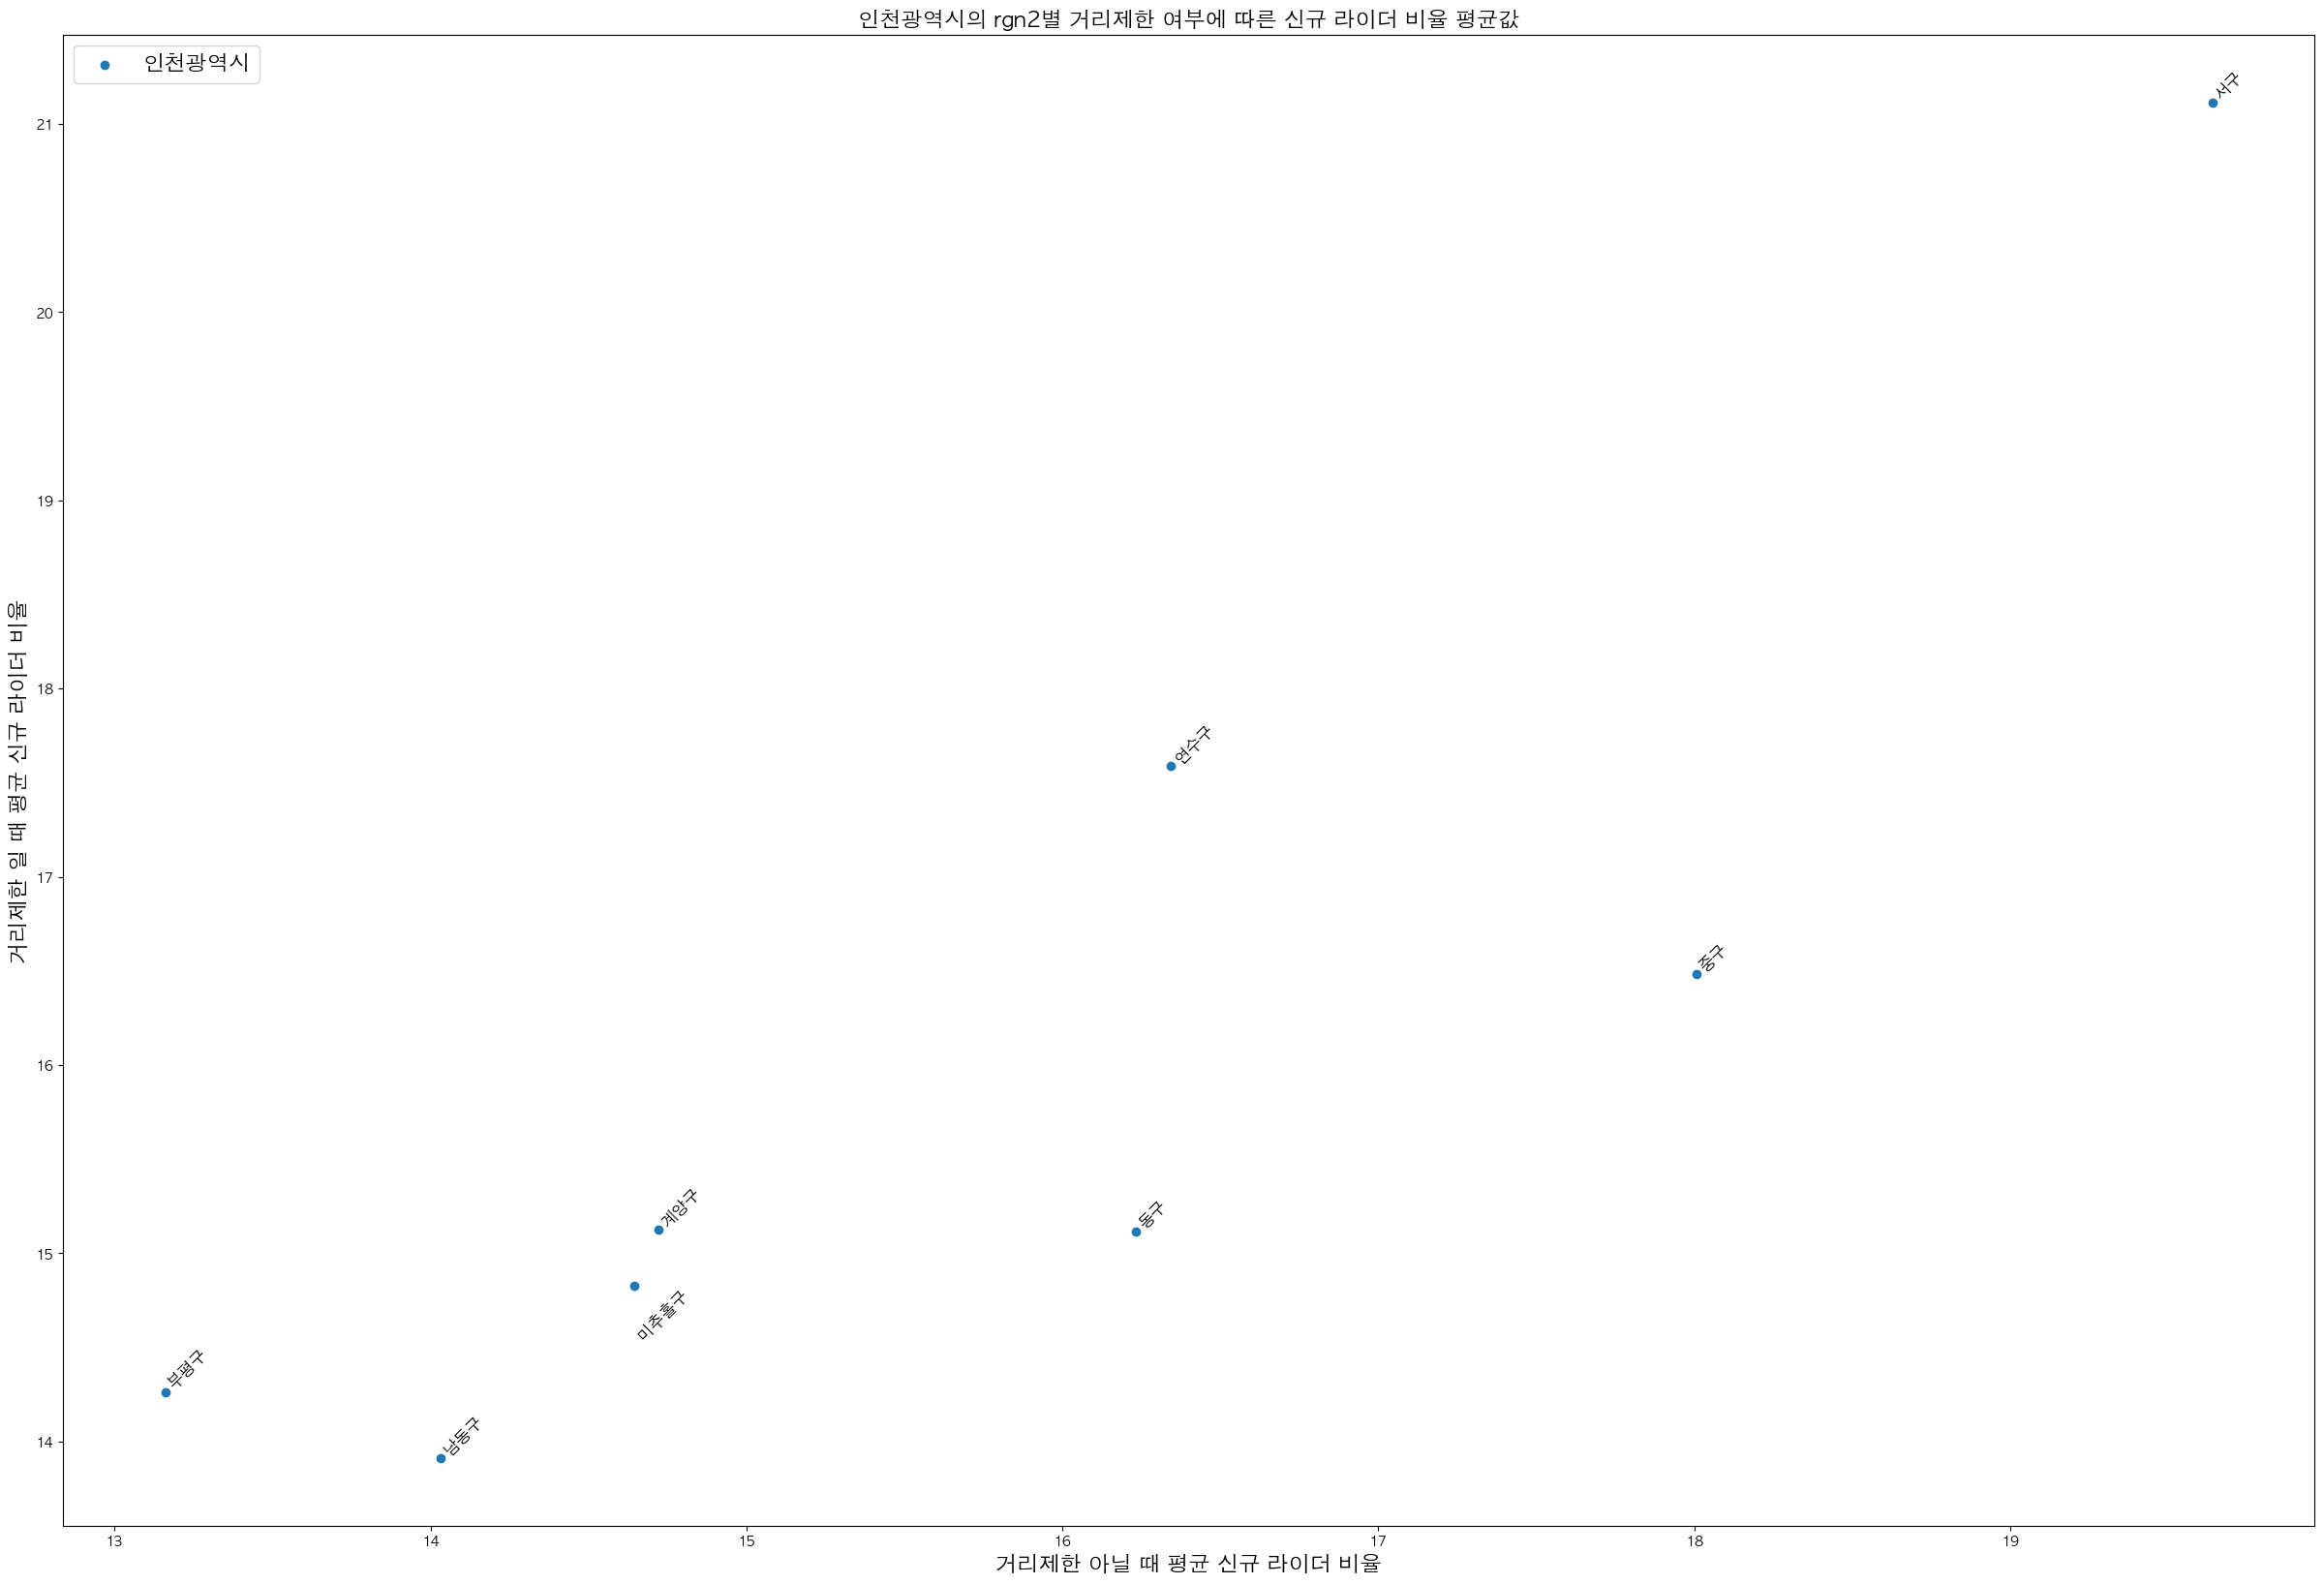

In [50]:
groups = {
    "강원도-제주": ["강원도", "제주특별자치도"],
    "경상도-울산-대구": ["경상남도", "경상북도", "울산광역시", "대구광역시"],
    "전라도-광주": ["전라남도", "전라북도", "광주광역시"],
    "충청-대전-세종": ["대전광역시", "세종특별자치시", "충청남도", "충청북도"]
}

os.makedirs('CRM-effect-analyst-/graphs', exist_ok = True)

# 나머지 지역을 개별적으로 추가
for rgn in unique_rgn1:
    if not any(rgn in group for group in groups.values()):
        groups[rgn] = [rgn]

# 각 그룹별로 그래프 그리기
for group_name, regions in groups.items():
    plt.figure(figsize=(30, 20))
    texts = []

    for rgn in regions:
        current_data = new_df.loc[rgn]
        plt.scatter(current_data[0], current_data[1], label=rgn)

        # 각 지점에 'rgn2_nm' 표시 (텍스트 크기 조정)
        for i, txt in enumerate(current_data.index):
            texts.append(plt.text(current_data[0].iloc[i], current_data[1].iloc[i], txt, ha='right', va='bottom', rotation = 45, fontsize=12))

    plt.xlabel('거리제한 아닐 때 평균 신규 라이더 비율', fontsize=16)
    plt.ylabel('거리제한 일 때 평균 신규 라이더 비율', fontsize=16)
    plt.title(f'{group_name}의 rgn2별 거리제한 여부에 따른 신규 라이더 비율 평균값', fontsize=16)
    plt.legend(loc='upper left', fontsize=16)

    # 텍스트 위치 조정
    adjust_text(texts, expand_points=(0.5, 0.5))

    plt.savefig(f'CRM-effect-analyst-/graphs/{group_name}.png')
    plt.show()


In [48]:
median_rvalue = data.groupby('rgn2_nm')['r_value'].median()
mean_rvalue = data.groupby('rgn2_nm')['r_value'].mean()
std_rvalue = data.groupby('rgn2_nm')['r_value'].std()

table = pd.concat([median_rvalue, mean_rvalue, std_rvalue], keys = ['median', 'mean', 'std'],  axis = 1)
print(table)


            median       mean       std
rgn2_nm                                
강남구      37.169770  37.095343  1.785386
강동구      30.630412  31.725203  2.697135
강릉시      37.375922  37.164909  3.675414
강북구      28.639709  28.643415  2.322593
강서구      29.316822  28.066697  6.497316
...            ...        ...       ...
포항시 남구   37.055838  37.020540  2.842276
포항시 북구   39.455128  39.491369  3.298185
하남시      25.430077  26.220941  2.689073
해운대구     26.644232  27.189829  2.104148
화성시      28.171618  28.672160  2.381734

[124 rows x 3 columns]
